## ReMECS -- Real-time Multimodal Emotion Classification Syatem

## Using multimodal data stream [EEG+EDA+RESP_BELT] 
## Using LR + SGD + One pass + Weighted Majority Voting

## Modifications:
- New Feature Set for EDA and Resp Belt. 
- Feature normalization is done.
- RECS with other modalities (EDA + Resp Belt) is incorporated for Real-time Multimodal Emotion Classification System (ReMECS).
- Weighted Majority Vote is used for Decision Fusion. 
- Sliding window is used to extract better features.


## Date: 19 MARCH 2021 at 10:10 AM

In [1]:
#============================
# Import important libraries
#============================
import pandas as pd 
import numpy as np
import math
import scipy
import pywt
from creme import metrics
import time
import datetime
from statistics import mode
from scipy import stats
from sklearn import preprocessing
from collections import defaultdict, Counter
from scipy.special import expit
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt


# from LogisticRegressionClassifierASGD import *
from LogisticRegressionNormal import *
from window_slider import Slider

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)> 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):    
    list_values = list_values[0,:]
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [3]:
#======================================================
# EDA Feature Extraction (Wavelet Features)
#======================================================
def extract_eda_features(raw_eda):
    features =[]
    EDA = raw_eda
    list_coeff = pywt.wavedec(EDA, 'db4', level=3)
    
#     print(list_coeff)
    for coeff in list_coeff:
        features += get_features(coeff)
    return features


In [4]:
#======================================================
# RESP BELT Feature Extraction (Wavelet Features)
#======================================================

def extract_resp_belt_features(raw_data):
    features =[]
    resp_belt = raw_data
    list_coeff = pywt.wavedec(resp_belt, 'db4', level=3)
    
#     print(list_coeff)
    for coeff in list_coeff:
        features += get_features(coeff)
    return features

In [5]:
def eeg_features(raw_data):
    ch = 0
    features= []
    def calculate_entropy(list_values):
        counter_values = Counter(list_values).most_common()
        probabilities = [elem[1]/len(list_values) for elem in counter_values]
        entropy=scipy.stats.entropy(probabilities)
        return entropy

    def calculate_statistics(list_values):
        median = np.nanpercentile(list_values, 50)
        mean = np.nanmean(list_values)
        std = np.nanstd(list_values)
        var = np.nanvar(list_values)
        rms = np.nanmean(np.sqrt(list_values**2))
        return [median, mean, std, var, rms]

    def get_features(list_values):    
    #     list_values = list_values[0,:]
        entropy = calculate_entropy(list_values)
        statistics = calculate_statistics(list_values)
        return [entropy] + statistics
    
    for i in range(raw_data.shape[0]):
        ch_data = raw_data[i]
        list_coeff = pywt.wavedec(ch_data, 'db4', level=5)
        for coeff in list_coeff:
            features += get_features(coeff)
            
        ch = ch+1
    return features

In [6]:
##===================================================
# EEG data read from files
##===================================================
def eeg_data(p,v):
    file_eeg = '/home/gp/Desktop/MER_arin/data/eeg_data/'+str(p)+'_data_DEAP'+'.csv'
    print(file_eeg)
    df = pd.read_csv(file_eeg,sep=',', header = None, engine='python')
    eeg_sig = df.loc[df.iloc[:,1] == v]
    return eeg_sig

##===================================================
# EDA data read from files
##===================================================
def eda_data(p,v):
    file_eda = '/home/gp/Desktop/MER_arin/data/eda_data/'+str(p)+'_GSR_data_from_DEAP.csv'
    print(file_eda)
    df = pd.read_csv(file_eda,sep=',', header = None, engine='python')
    eda_sig = df.loc[df.iloc[:,1] == v]
    return eda_sig

##===================================================
# Resp data read from files
##===================================================
def resp_data(p,v):
    file_resp = '/home/gp/Desktop/MER_arin/data/resp_data/'+str(p)+'_Respiration_data_from_DEAP.csv'
    print(file_resp)
    df = pd.read_csv(file_resp,sep=',', header = None, engine='python')
    resp_sig = df.loc[df.iloc[:,1] == v]
    return resp_sig

In [7]:
#=======================================
# MAIN PROGRAM STARTS HERE
#=======================================

segment_in_sec = 10 #in sec
bucket_size = int((8064/60)*segment_in_sec)  #8064 is for 60 sec record
overlap_count = 0

num_classifiers = 3 #Total number of classifiers
w_val =np.ones(num_classifiers)/num_classifiers #Weights for valence classifiers
w_aro =np.ones(num_classifiers)/num_classifiers #Weights for valence classifiers
beta = 0.5

# l_max =0.9999
# lr_min = 0.0001
eta = 0.05
b =1 


n_epoch =1
epochs =  1 #epoch is 1 because the model will be trained only once
# optimizer= 'sgd' #optimizer

optimizer= 'SGD' #optimizer
classifier = 'LogisticRegression_'+str(optimizer)
c = 0
run = 1

participant = 32
videos = 40

global eeg_emotion, eda_emotion, resp_emotion, mer_emotion, all_eta
eeg_emotion = []
eda_emotion = []
resp_emotion = []
mer_emotion = []

all_eta =[]
init_m = 0

#================================================
# Performance matric declaration here
#================================================
mer_acc_val = metrics.Accuracy() #Accuracy
mer_f1m_val = metrics.F1() #F1 measure  
mer_acc_aro = metrics.Accuracy() #Accuracy
mer_f1m_aro = metrics.F1() #F1 measure
mer_roc_val = metrics.ROCAUC()
mer_roc_aro = metrics.ROCAUC() 
mer_mcc_val = metrics.MCC()
mer_mcc_aro = metrics.MCC()



eeg_acc_val = metrics.Accuracy() #Accuracy
eeg_f1m_val = metrics.F1() #F1 measure  
eeg_acc_aro = metrics.Accuracy() #Accuracy
eeg_f1m_aro = metrics.F1() #F1 measure
eeg_roc_val = metrics.ROCAUC()
eeg_roc_aro = metrics.ROCAUC()
eeg_mcc_val = metrics.MCC()
eeg_mcc_aro = metrics.MCC()

eda_acc_val = metrics.Accuracy() #Accuracy
eda_f1m_val = metrics.F1() #F1 measure  
eda_acc_aro = metrics.Accuracy() #Accuracy
eda_f1m_aro = metrics.F1() #F1 measure
eda_roc_val = metrics.ROCAUC()
eda_roc_aro = metrics.ROCAUC()
eda_mcc_val = metrics.MCC()
eda_mcc_aro = metrics.MCC()

resp_acc_val = metrics.Accuracy() #Accuracy
resp_f1m_val = metrics.F1() #F1 measure  
resp_acc_aro = metrics.Accuracy() #Accuracy
resp_f1m_aro = metrics.F1() #F1 measure
resp_roc_val = metrics.ROCAUC()
resp_roc_aro = metrics.ROCAUC()
resp_mcc_val = metrics.MCC()
resp_mcc_aro = metrics.MCC()
    
itr = 0 #controls the learning rate


for ii in range(0,participant):


        # if(ii >2):
        # 	break

        p =ii+1
        for jj in range(0,videos):
            v = jj+1
            p_v = 'Person:'+ ' ' +str(p)+ ' ' +'Video:'+str(v)
            
            emotion_label =[]
            
            print('------------------------------------------------')
            ##===================================================
            # Data read from files
            ##===================================================
            eeg_sig = eeg_data(p,v)
            eda_sig = eda_data(p,v)
            resp_sig = resp_data(p,v)
            
            #=================================================
            #emotion labels (valence, arousal) mapping 0-1
            #=================================================
            val = eeg_sig.iloc[0,8067]
            aro = eeg_sig.iloc[0,8068]
            
            #valence emotion maping 0-> low valence and 1-> high valence

            if (val >5):
                vl = 1 #high valence
            else:
                vl = 0 #low valence

            #arousal emotion maping 0-> low arousal and 1-> high high arousal
            if (aro >5):
                al = 1 #high arousal
            else:
                al = 0 #low arousal
                
            y_act_val = vl
            y_act_aro = al 
            
            
            #=========================================
            # Sliding window starts here 
            #=========================================
            slider_eeg = Slider(bucket_size,overlap_count)
            slider_eda = Slider(bucket_size,overlap_count)
            slider_resp = Slider(bucket_size,overlap_count)
            
            eeg_sig = np.array(eeg_sig.iloc[range(0,32),range(3,8067)]) #keeping only eeg signals
            eda_sig = np.array(eda_sig.iloc[:,range(3,8067)]) #keeping only eda signals
            resp_sig = np.array(resp_sig.iloc[:,range(3,8067)]) #keeping only resp signals
            
            slider_eeg.fit(eeg_sig)
            slider_eda.fit(eda_sig)
            slider_resp.fit(resp_sig)

            while True:
                window_data_eeg = slider_eeg.slide()
                window_data_eda = slider_eda.slide() 
                window_data_resp = slider_resp.slide() 
                
                #=================================================
                # Feature extraction from EEG
                #=================================================
                features_eeg = eeg_features(window_data_eeg)
                eeg = np.array([features_eeg])  #EEG raw feature vector
                x_eeg = preprocessing.normalize(eeg) # EEG normalized features [0,1] 
                
                
                #=================================================
                # Feature extraction from EDA
                #=================================================
                eda_features = extract_eda_features(np.array(window_data_eda))
                eda = np.array([eda_features]) #EDA raw feature vector
                x_eda = preprocessing.normalize(eda) #EDA normalized features
                
                #=================================================
                # Feature extraction from Resp belt
                #=================================================

                resp_features = extract_resp_belt_features(np.array(window_data_resp))
                resp = np.array([resp_features]) #RESP BELT raw feature vector
                x_resp = preprocessing.normalize(resp) #RESP BELT normalized features
            
            
                #===================================================
                # Model initialization
                #===================================================
                if init_m == 0:
                    print('EEG Feature shape{}:'.format(x_eeg.shape))
                    print('EDA Feature shape{}:'.format(x_eda.shape))
                    print('RESP BELT Feature shape{}:'.format(x_resp.shape))

                    #========================
                    # For EEG data
                    #========================
                    eeg_model_val = logistic_regression(x_eeg,n_epoch) 
                    eeg_model_aro = logistic_regression(x_eeg,n_epoch)

                    #========================
                    # For EDA data
                    #========================
                    eda_model_val = logistic_regression(x_eda,n_epoch) 
                    eda_model_aro = logistic_regression(x_eda,n_epoch)

                    #========================
                    # For Resp Belt data
                    #========================
                    resp_model_val = logistic_regression(x_resp,n_epoch) 
                    resp_model_aro = logistic_regression(x_resp,n_epoch)


                    init_m = init_m+1


                #===============================================================
                # Emotion Classification --> Valence and Arousal
                #===============================================================

                #===========================================
                # From EEG data -- RECS System
                #===========================================

                #Valence classification EEG

                #Test the model first 
                y_pred_val_eeg = eeg_model_val.predict_once(x_eeg,c)

                #Train the model once
                eeg_model_val.fit_once(x_eeg,y_act_val, eta,c)

                eeg_acc_val = eeg_acc_val.update(y_act_val, y_pred_val_eeg)  # update the accuracy metric

                eeg_f1m_val = eeg_f1m_val.update(y_act_val, y_pred_val_eeg) #update f1 measure metric
                
                eeg_roc_val = eeg_roc_val.update(y_act_val, y_pred_val_eeg)
                
                eeg_mcc_val = eeg_mcc_val.update(y_act_val, y_pred_val_eeg)

                #Arousal classification EEG

                #Test the model first 
                y_pred_aro_eeg = eeg_model_aro.predict_once(x_eeg,c)

                #Train the model once
                eeg_model_aro.fit_once(x_eeg,y_act_aro, eta,c)

                eeg_acc_aro = eeg_acc_aro.update(y_act_aro, y_pred_aro_eeg)  # update the accuracy metric

                eeg_f1m_aro = eeg_f1m_aro.update(y_act_aro, y_pred_aro_eeg) #update f1 measure metric
                
                eeg_roc_aro = eeg_roc_aro.update(y_act_aro, y_pred_aro_eeg)
                
                eeg_mcc_aro = eeg_mcc_aro.update(y_act_aro, y_pred_aro_eeg)

                
                #===========================================
                # From EDA data 
                #===========================================

                #Valence classification EDA

                #Test the model first 
                y_pred_val_eda = eda_model_val.predict_once(x_eda,c)

                #Train the model once
                eda_model_val.fit_once(x_eda,y_act_val, eta,c)

                eda_acc_val = eda_acc_val.update(y_act_val, y_pred_val_eda)  # update the accuracy metric

                eda_f1m_val = eda_f1m_val.update(y_act_val, y_pred_val_eda) #update f1 measure metric
                
                eda_roc_val = eda_roc_val.update(y_act_val, y_pred_val_eda)
                
                eda_mcc_val = eda_mcc_val.update(y_act_val, y_pred_val_eda)

                #Arousal classification EDA
                #Test the model first 
                y_pred_aro_eda = eda_model_aro.predict_once(x_eda,c)

                #Train the model once
                eda_model_aro.fit_once(x_eda,y_act_aro, eta,c)

                eda_acc_aro = eda_acc_aro.update(y_act_aro, y_pred_aro_eda)  # update the accuracy metric

                eda_f1m_aro = eda_f1m_aro.update(y_act_aro, y_pred_aro_eda) #update f1 measure metric
                
                eda_roc_aro = eda_roc_aro.update(y_act_aro, y_pred_aro_eda)
                
                eda_mcc_aro = eda_mcc_aro.update(y_act_aro, y_pred_aro_eda)



                #===========================================
                # From Resp Belt data
                #===========================================

                #Valence classification Resp Belt

                #Test the model first 
                y_pred_val_resp = resp_model_val.predict_once(x_resp,c)

                #Train the model once
                resp_model_val.fit_once(x_resp,y_act_val, eta,c)

                resp_acc_val = resp_acc_val.update(y_act_val, y_pred_val_resp)  # update the accuracy metric

                resp_f1m_val = resp_f1m_val.update(y_act_val, y_pred_val_resp) #update f1 measure metric
                
                resp_roc_val = resp_roc_val.update(y_act_val, y_pred_val_resp)
                
                resp_mcc_val = resp_roc_val.update(y_act_val, y_pred_val_resp)

                #Arousal classification Resp Belt
                #Test the model first 
                y_pred_aro_resp = resp_model_aro.predict_once(x_resp,c)

                #Train the model once
                resp_model_aro.fit_once(x_resp,y_act_aro, eta,c)

                resp_acc_aro = resp_acc_aro.update(y_act_aro, y_pred_aro_resp)  # update the accuracy metric

                resp_f1m_aro = resp_f1m_aro.update(y_act_aro, y_pred_aro_resp) #update f1 measure metric
                
                resp_roc_aro = resp_roc_aro.update(y_act_aro, y_pred_aro_resp)
                
                resp_mcc_aro = resp_mcc_aro.update(y_act_aro, y_pred_aro_resp)
                
                c = c+1

                if slider_eeg.reached_end_of_list(): break
                
            
            
            emotion_label.append([y_pred_val_eeg,y_pred_aro_eeg]) #appending valence & arousal predicted EEG
            emotion_label.append([y_pred_val_eda, y_pred_aro_eda]) #appending valence & arousal predicted EDA
            emotion_label.append([y_pred_val_resp, y_pred_aro_resp]) #appending valence & arousal predicted resp

            emotion_label = np.array(emotion_label)
            
                    
            #==============================================================
            # Decision label ensemble --> Weighted Majority Voting
            #==============================================================
            val_label = emotion_label[:,0]
            aro_label = emotion_label[:,1]
            
            #------------------------------------------
            # Valence Class ensemble
            #------------------------------------------
            
            p_val = np.dot([w_val],val_label)
            y_prdt_mer_val = (p_val -0.5)
            if(y_prdt_mer_val > 0):
                mer_val = 1
            else:
                mer_val = 0

            for i in range(val_label.shape[0]):
                if(val_label[i] != y_act_val):
                    w_val[i] = beta*w_val[i]
            
            w_val_sum = sum(w_val) #total sum of weights
            
            w_val = np.array(w_val/w_val_sum) #weight rescaling
            
            #------------------------------------------
            # Arousal Class ensemble
            #------------------------------------------            
            p_val = np.dot([w_aro],aro_label)
            y_prdt_mer_aro = (p_val-0.5)
            if(y_prdt_mer_aro > 0):
                mer_aro = 1
            else:
                mer_aro = 0

            for i in range(aro_label.shape[0]):
                if(aro_label[i] != y_act_aro):
                    w_aro[i] = beta*w_aro[i]
            
            
            w_aro_sum = sum(w_aro) #total sum of weights
            
            w_aro = np.array(w_aro/w_aro_sum) #weight rescaling
            
            #========================================================
            # ReMECS performance metric 
            #========================================================
            mer_acc_val = mer_acc_val.update(y_act_val, mer_val)
            mer_f1m_val = mer_f1m_val.update(y_act_val, mer_val)
            mer_roc_val = mer_roc_val.update(y_act_val, mer_val)
            mer_mcc_val = mer_mcc_val.update(y_act_val, mer_val)
            
            mer_acc_aro = mer_acc_aro.update(y_act_aro, mer_aro)
            mer_f1m_aro = mer_f1m_aro.update(y_act_aro, mer_aro)
            mer_roc_aro = mer_roc_aro.update(y_act_aro, mer_aro)
            mer_mcc_aro = mer_mcc_aro.update(y_act_aro, mer_aro)
            
            eeg_emotion.append(np.array([p,v,eeg_acc_val.get(), eeg_f1m_val.get(), eeg_roc_val.get(),eeg_mcc_val.get(),
                                         eeg_acc_aro.get(), eeg_f1m_aro.get(),eeg_roc_aro.get(), eeg_mcc_aro.get(), 
                                         y_act_val, y_pred_val_eeg, y_act_aro, y_pred_aro_eeg]))
            
            eda_emotion.append(np.array([p,v,eda_acc_val.get(), eda_f1m_val.get(), eda_roc_val.get(),eda_mcc_val.get(),
                                         eda_acc_aro.get(), eda_f1m_aro.get(), eda_roc_aro.get(), eda_mcc_aro.get(),
                                         y_act_val, y_pred_val_eda, y_act_aro, y_pred_aro_eda]))
            
            resp_emotion.append(np.array([p,v, resp_acc_val.get(), resp_f1m_val.get(), resp_roc_val.get(), resp_mcc_val.get(),
                                          resp_acc_aro.get(),resp_f1m_aro.get(), resp_roc_aro.get(), resp_mcc_aro.get(), 
                                          y_act_val, y_pred_val_resp, y_act_aro, y_pred_aro_resp]))
            
            mer_emotion.append(np.array([p,v,mer_acc_val.get(), mer_f1m_val.get(), mer_roc_val.get(), mer_mcc_val.get(),
                                         mer_acc_aro.get(), mer_f1m_aro.get(), mer_roc_aro.get(), mer_mcc_aro.get(), 
                                         y_act_val, mer_val, y_act_aro, mer_aro]))
            print('===============================================================')
            print(p_v)
            print('Actual emotion [valence: {}, arousal: {}]'.format(y_act_val, y_act_aro))
            print('Single modal Predicted emotion')
            print('[valence, arousal]:')
            print(emotion_label)
            
            print('MER Predicted emotion [valence: {}, arousal: {}]'.format(mer_val, mer_aro))            
            print('..................................................')
            print('EEG')

            print("Valence Accuracy:{}".format(round(eeg_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(eeg_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(eeg_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(eeg_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(eeg_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(eeg_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(eeg_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(eeg_mcc_aro.get(),4)))

            print('..................................................')
            print('EDA')

            print("Valence Accuracy:{}".format(round(eda_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(eda_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(eda_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(eda_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(eda_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(eda_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(eda_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(eda_mcc_aro.get(),4)))


            print('..................................................')
            print('RESP BELT')

            print("Valence Accuracy:{}".format(round(resp_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(resp_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(resp_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(resp_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(resp_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(resp_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(resp_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(resp_mcc_aro.get(),4)))

            print('..................................................')
            print('MER model')

            print("Valence Accuracy:{}".format(round(mer_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(mer_f1m_val.get(),4)))
            print("Valence ROC score:{}".format(round(mer_roc_val.get(),4)))
            print("Valence MCC score:{}".format(round(mer_mcc_val.get(),4)))
            
            print("Arousal Accuracy:{}".format(round(mer_acc_aro.get(),4)))
            print("Arousal F1 score:{}".format(round(mer_f1m_aro.get(),4)))
            print("Arousal ROC score:{}".format(round(mer_roc_aro.get(),4)))
            print("Arousal MCC score:{}".format(round(mer_mcc_aro.get(),4)))
                
                
            


------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
EEG Feature shape(1, 1152):
EDA Feature shape(1, 48):
RESP BELT Feature shape(1, 48):
Person: 1 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.8333
Valence F1 score:0.9091
Valence ROC score:-0.0
Valence MCC score:0.0
Arousal Accuracy:0.0
Arousal F1 score:0.0
Arousal ROC score:-0.0
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.8333
Valence F1 score:0.9091
Valence ROC score:-0.0
Valence MCC score:0.0
Arousal Accuracy:0.8333
Arousal F1 score:0.9091
Arousal ROC score:-0.0
Arousal MCC score:0.0
................

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:7
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.8333
Valence F1 score:0.9091
Valence ROC score:0.4861
Valence MCC score:-0.0638
Arousal Accuracy:0.4286
Arousal F1 score:0.0
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.8333
Valence F1 score:0.9091
Valence ROC score:0.4861
Valence MCC score:-0.0638
Arousal Accuracy:0.5476
Arousal F1 score:0.7077
Arousal ROC score:0.4792
Arousal MCC score:-0.1353
..................................................
RESP BELT
Valence Accuracy:0.1429
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5476
Arousal F1 sc

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5256
Valence F1 score:0.6891
Valence ROC score:0.4881
Valence MCC score:-0.1055
Arousal Accuracy:0.6923
Arousal F1 score:0.0
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.5256
Valence F1 score:0.6891
Valence ROC score:0.4881
Valence MCC score:-0.1055
Arousal Accuracy:0.2949
Arousal F1 score:0.4554
Arousal ROC score:0.4792
Arousal MCC score:-0.1709
..................................................
RESP BELT
Valence Accuracy:0.4615
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.2949
Arousal F1 s

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5175
Valence F1 score:0.6821
Valence ROC score:0.4917
Valence MCC score:-0.0892
Arousal Accuracy:0.5263
Arousal F1 score:0.0
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.5175
Valence F1 score:0.6821
Valence ROC score:0.4917
Valence MCC score:-0.0892
Arousal Accuracy:0.4649
Arousal F1 score:0.6347
Arousal ROC score:0.4907
Arousal MCC score:-0.0992
..................................................
RESP BELT
Valence Accuracy:0.4737
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4649
Arousal F1 s

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:25
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.6333
Valence F1 score:0.7755
Valence ROC score:0.4948
Valence MCC score:-0.0614
Arousal Accuracy:0.48
Arousal F1 score:0.0
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.6333
Valence F1 score:0.7755
Valence ROC score:0.4948
Valence MCC score:-0.0614
Arousal Accuracy:0.5133
Arousal F1 score:0.6784
Arousal ROC score:0.4936
Arousal MCC score:-0.0787
..................................................
RESP BELT
Valence Accuracy:0.36
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5133
Arousal F1 score

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5753
Valence F1 score:0.7304
Valence ROC score:0.4954
Valence MCC score:-0.0625
Arousal Accuracy:0.4839
Arousal F1 score:0.0
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.5753
Valence F1 score:0.7304
Valence ROC score:0.4954
Valence MCC score:-0.0625
Arousal Accuracy:0.5108
Arousal F1 score:0.6762
Arousal ROC score:0.4948
Arousal MCC score:-0.0712
..................................................
RESP BELT
Valence Accuracy:0.4194
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5108
Arousal F1 s

/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
Person: 1 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.482
Valence F1 score:0.6505
Valence ROC score:0.4954
Valence MCC score:-0.0691
Arousal Accuracy:0.4324
Arousal F1 score:0.0
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.482
Valence F1 score:0.6505
Valence ROC score:0.4954
Valence MCC score:-0.0691
Arousal Accuracy:0.5631
Arousal F1 score:0.7205
Arousal ROC score:0.496
Arousal MCC score:-0.0587
..................................................
RESP BELT
Valence Accuracy:0.5135
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5631
Arousal F1 scor

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5078
Valence F1 score:0.6735
Valence ROC score:0.4962
Valence MCC score:-0.0609
Arousal Accuracy:0.3721
Arousal F1 score:0.0
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.5078
Valence F1 score:0.6735
Valence ROC score:0.4962
Valence MCC score:-0.0609
Arousal Accuracy:0.624
Arousal F1 score:0.7685
Arousal ROC score:0.4969
Arousal MCC score:-0.048
..................................................
RESP BELT
Valence Accuracy:0.4884
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.624
Arousal F1 score

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5272
Valence F1 score:0.6904
Valence ROC score:0.4968
Valence MCC score:-0.0549
Arousal Accuracy:0.4116
Arousal F1 score:0.0226
Arousal ROC score:0.5016
Arousal MCC score:0.0155
..................................................
EDA
Valence Accuracy:0.5272
Valence F1 score:0.6904
Valence ROC score:0.4968
Valence MCC score:-0.0549
Arousal Accuracy:0.5884
Arousal F1 score:0.7409
Arousal ROC score:0.4971
Arousal MCC score:-0.0485
..................................................
RESP BELT
Valence Accuracy:0.4694
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5884
Arou

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5606
Valence F1 score:0.7184
Valence ROC score:0.4973
Valence MCC score:-0.0485
Arousal Accuracy:0.4333
Arousal F1 score:0.0697
Arousal ROC score:0.511
Arousal MCC score:0.0665
..................................................
EDA
Valence Accuracy:0.5606
Valence F1 score:0.7184
Valence ROC score:0.4973
Valence MCC score:-0.0485
Arousal Accuracy:0.5788
Arousal F1 score:0.7332
Arousal ROC score:0.4974
Arousal MCC score:-0.0467
..................................................
RESP BELT
Valence Accuracy:0.4364
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5788
Arou

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5874
Valence F1 score:0.7401
Valence ROC score:0.4977
Valence MCC score:-0.0436
Arousal Accuracy:0.4235
Arousal F1 score:0.0705
Arousal ROC score:0.5085
Arousal MCC score:0.0491
..................................................
EDA
Valence Accuracy:0.5874
Valence F1 score:0.7401
Valence ROC score:0.4977
Valence MCC score:-0.0436
Arousal Accuracy:0.5874
Arousal F1 score:0.7401
Arousal ROC score:0.4977
Arousal MCC score:-0.0436
..................................................
RESP BELT
Valence Accuracy:0.4098
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5874
Aro

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:27
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5796
Valence F1 score:0.7339
Valence ROC score:0.4979
Valence MCC score:-0.0423
Arousal Accuracy:0.4154
Arousal F1 score:0.0711
Arousal ROC score:0.5064
Arousal MCC score:0.0355
..................................................
EDA
Valence Accuracy:0.5796
Valence F1 score:0.7339
Valence ROC score:0.4979
Valence MCC score:-0.0423
Arousal Accuracy:0.5945
Arousal F1 score:0.7457
Arousal ROC score:0.4979
Arousal MCC score:-0.041
..................................................
RESP BELT
Valence Accuracy:0.4179
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5945
Arou

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.532
Valence F1 score:0.6945
Valence ROC score:0.4979
Valence MCC score:-0.0447
Arousal Accuracy:0.3995
Arousal F1 score:0.0772
Arousal ROC score:0.5085
Arousal MCC score:0.0453
..................................................
EDA
Valence Accuracy:0.532
Valence F1 score:0.6945
Valence ROC score:0.4979
Valence MCC score:-0.0447
Arousal Accuracy:0.6142
Arousal F1 score:0.761
Arousal ROC score:0.4981
Arousal MCC score:-0.0377
..................................................
RESP BELT
Valence Accuracy:0.4658
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.6142
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
Person: 2 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5042
Valence F1 score:0.6704
Valence ROC score:0.4979
Valence MCC score:-0.0454
Arousal Accuracy:0.4198
Arousal F1 score:0.0803
Arousal ROC score:0.5083
Arousal MCC score:0.0436
..................................................
EDA
Valence Accuracy:0.5042
Valence F1 score:0.6704
Valence ROC score:0.4979
Valence MCC score:-0.0454
Arousal Accuracy:0.5928
Arousal F1 score:0.7444
Arousal ROC score:0.4982
Arousal MCC score:-0.0379
..................................................
RESP BELT
Valence Accuracy:0.4937
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5928
Aro

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:5
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5294
Valence F1 score:0.6915
Valence ROC score:0.5002
Valence MCC score:0.0037
Arousal Accuracy:0.4078
Arousal F1 score:0.0848
Arousal ROC score:0.4612
Arousal MCC score:-0.1398
..................................................
EDA
Valence Accuracy:0.5275
Valence F1 score:0.6906
Valence ROC score:0.4981
Valence MCC score:-0.0418
Arousal Accuracy:0.5627
Arousal F1 score:0.7202
Arousal ROC score:0.4983
Arousal MCC score:-0.0389
..................................................
RESP BELT
Valence Accuracy:0.4706
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5627
Arou

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:11
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5495
Valence F1 score:0.7085
Valence ROC score:0.5004
Valence MCC score:0.006
Arousal Accuracy:0.4103
Arousal F1 score:0.1056
Arousal ROC score:0.4391
Arousal MCC score:-0.1864
..................................................
EDA
Valence Accuracy:0.5476
Valence F1 score:0.7077
Valence ROC score:0.4983
Valence MCC score:-0.0388
Arousal Accuracy:0.5366
Arousal F1 score:0.6985
Arousal ROC score:0.4983
Arousal MCC score:-0.0397
..................................................
RESP BELT
Valence Accuracy:0.4505
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5366
Arou

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:17
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.567
Valence F1 score:0.7231
Valence ROC score:0.5005
Valence MCC score:0.0079
Arousal Accuracy:0.4158
Arousal F1 score:0.1005
Arousal ROC score:0.4195
Arousal MCC score:-0.2292
..................................................
EDA
Valence Accuracy:0.5653
Valence F1 score:0.7223
Valence ROC score:0.4985
Valence MCC score:-0.0363
Arousal Accuracy:0.5034
Arousal F1 score:0.6697
Arousal ROC score:0.4983
Arousal MCC score:-0.0411
..................................................
RESP BELT
Valence Accuracy:0.433
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5034
Arous

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5583
Valence F1 score:0.7159
Valence ROC score:0.4961
Valence MCC score:-0.0431
Arousal Accuracy:0.4126
Arousal F1 score:0.1125
Arousal ROC score:0.4031
Arousal MCC score:-0.2541
..................................................
EDA
Valence Accuracy:0.5615
Valence F1 score:0.7192
Valence ROC score:0.4986
Valence MCC score:-0.0355
Arousal Accuracy:0.4838
Arousal F1 score:0.6521
Arousal ROC score:0.4983
Arousal MCC score:-0.0414
..................................................
RESP BELT
Valence Accuracy:0.4369
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4838
Ar

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:29
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5459
Valence F1 score:0.7051
Valence ROC score:0.4965
Valence MCC score:-0.0343
Arousal Accuracy:0.4144
Arousal F1 score:0.1072
Arousal ROC score:0.3886
Arousal MCC score:-0.279
..................................................
EDA
Valence Accuracy:0.5489
Valence F1 score:0.7088
Valence ROC score:0.4986
Valence MCC score:-0.0354
Arousal Accuracy:0.4572
Arousal F1 score:0.6275
Arousal ROC score:0.4983
Arousal MCC score:-0.0425
..................................................
RESP BELT
Valence Accuracy:0.4495
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4572
Aro

/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
Person: 3 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5275
Valence F1 score:0.6883
Valence ROC score:0.498
Valence MCC score:-0.0169
Arousal Accuracy:0.4203
Arousal F1 score:0.1266
Arousal ROC score:0.3917
Arousal MCC score:-0.2639
..................................................
EDA
Valence Accuracy:0.529
Valence F1 score:0.6919
Valence ROC score:0.4986
Valence MCC score:-0.0358
Arousal Accuracy:0.4507
Arousal F1 score:0.6214
Arousal ROC score:0.4984
Arousal MCC score:-0.0419
..................................................
RESP BELT
Valence Accuracy:0.4696
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4507
Arou

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5262
Valence F1 score:0.6867
Valence ROC score:0.4982
Valence MCC score:-0.0141
Arousal Accuracy:0.416
Arousal F1 score:0.1486
Arousal ROC score:0.3991
Arousal MCC score:-0.2451
..................................................
EDA
Valence Accuracy:0.5275
Valence F1 score:0.6907
Valence ROC score:0.4987
Valence MCC score:-0.035
Arousal Accuracy:0.4697
Arousal F1 score:0.6392
Arousal ROC score:0.4985
Arousal MCC score:-0.0394
..................................................
RESP BELT
Valence Accuracy:0.4711
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4697
Arous

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:7
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5249
Valence F1 score:0.6858
Valence ROC score:0.4982
Valence MCC score:-0.0141
Arousal Accuracy:0.4278
Arousal F1 score:0.1451
Arousal ROC score:0.4064
Arousal MCC score:-0.2313
..................................................
EDA
Valence Accuracy:0.5262
Valence F1 score:0.6896
Valence ROC score:0.4988
Valence MCC score:-0.0343
Arousal Accuracy:0.4633
Arousal F1 score:0.6332
Arousal ROC score:0.4986
Arousal MCC score:-0.0389
..................................................
RESP BELT
Valence Accuracy:0.4724
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4633
Aro

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5301
Valence F1 score:0.6903
Valence ROC score:0.4973
Valence MCC score:-0.021
Arousal Accuracy:0.4311
Arousal F1 score:0.1402
Arousal ROC score:0.4101
Arousal MCC score:-0.2263
..................................................
EDA
Valence Accuracy:0.5326
Valence F1 score:0.695
Valence ROC score:0.4988
Valence MCC score:-0.0331
Arousal Accuracy:0.4649
Arousal F1 score:0.6347
Arousal ROC score:0.4987
Arousal MCC score:-0.0379
..................................................
RESP BELT
Valence Accuracy:0.4662
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4649
Arou

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.536
Valence F1 score:0.6955
Valence ROC score:0.4976
Valence MCC score:-0.0191
Arousal Accuracy:0.4269
Arousal F1 score:0.1341
Arousal ROC score:0.4109
Arousal MCC score:-0.2283
..................................................
EDA
Valence Accuracy:0.5384
Valence F1 score:0.6999
Valence ROC score:0.4989
Valence MCC score:-0.032
Arousal Accuracy:0.4736
Arousal F1 score:0.6428
Arousal ROC score:0.4987
Arousal MCC score:-0.0364
..................................................
RESP BELT
Valence Accuracy:0.4604
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4736
Arou

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:25
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5276
Valence F1 score:0.6884
Valence ROC score:0.4975
Valence MCC score:-0.0208
Arousal Accuracy:0.4299
Arousal F1 score:0.1298
Arousal ROC score:0.4142
Arousal MCC score:-0.2234
..................................................
EDA
Valence Accuracy:0.5299
Valence F1 score:0.6927
Valence ROC score:0.4989
Valence MCC score:-0.0319
Arousal Accuracy:0.4747
Arousal F1 score:0.6438
Arousal ROC score:0.4988
Arousal MCC score:-0.0356
..................................................
RESP BELT
Valence Accuracy:0.469
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4747
Aro

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:31
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5221
Valence F1 score:0.6828
Valence ROC score:0.4997
Valence MCC score:-0.0026
Arousal Accuracy:0.4393
Arousal F1 score:0.1271
Arousal ROC score:0.4195
Arousal MCC score:-0.2129
..................................................
EDA
Valence Accuracy:0.5221
Valence F1 score:0.686
Valence ROC score:0.4989
Valence MCC score:-0.0317
Arousal Accuracy:0.4691
Arousal F1 score:0.6386
Arousal ROC score:0.4988
Arousal MCC score:-0.0353
..................................................
RESP BELT
Valence Accuracy:0.4768
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4691
Aro

/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
Person: 4 Video:37
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5032
Valence F1 score:0.6657
Valence ROC score:0.5001
Valence MCC score:0.0008
Arousal Accuracy:0.4544
Arousal F1 score:0.1259
Arousal ROC score:0.4262
Arousal MCC score:-0.198
..................................................
EDA
Valence Accuracy:0.5021
Valence F1 score:0.6686
Valence ROC score:0.4989
Valence MCC score:-0.0324
Arousal Accuracy:0.4575
Arousal F1 score:0.6278
Arousal ROC score:0.4988
Arousal MCC score:-0.0354
..................................................
RESP BELT
Valence Accuracy:0.4968
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4575
Arou

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:3
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.4898
Valence F1 score:0.6527
Valence ROC score:0.4927
Valence MCC score:-0.0447
Arousal Accuracy:0.4673
Arousal F1 score:0.1273
Arousal ROC score:0.4313
Arousal MCC score:-0.1851
..................................................
EDA
Valence Accuracy:0.4959
Valence F1 score:0.663
Valence ROC score:0.499
Valence MCC score:-0.0322
Arousal Accuracy:0.4468
Arousal F1 score:0.6177
Arousal ROC score:0.4989
Arousal MCC score:-0.0355
..................................................
RESP BELT
Valence Accuracy:0.5031
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4468
Arous

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:9
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.4832
Valence F1 score:0.645
Valence ROC score:0.4753
Valence MCC score:-0.11
Arousal Accuracy:0.4635
Arousal F1 score:0.1254
Arousal ROC score:0.4326
Arousal MCC score:-0.1841
..................................................
EDA
Valence Accuracy:0.5079
Valence F1 score:0.6736
Valence ROC score:0.499
Valence MCC score:-0.0309
Arousal Accuracy:0.4546
Arousal F1 score:0.6251
Arousal ROC score:0.4989
Arousal MCC score:-0.0343
..................................................
RESP BELT
Valence Accuracy:0.4911
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4546
Arousal

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.4819
Valence F1 score:0.6397
Valence ROC score:0.4698
Valence MCC score:-0.1139
Arousal Accuracy:0.4686
Arousal F1 score:0.1226
Arousal ROC score:0.4344
Arousal MCC score:-0.1808
..................................................
EDA
Valence Accuracy:0.5133
Valence F1 score:0.6784
Valence ROC score:0.4991
Valence MCC score:-0.03
Arousal Accuracy:0.4505
Arousal F1 score:0.6211
Arousal ROC score:0.4989
Arousal MCC score:-0.034
..................................................
RESP BELT
Valence Accuracy:0.4857
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4505
Arous

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.4761
Valence F1 score:0.6327
Valence ROC score:0.456
Valence MCC score:-0.1475
Arousal Accuracy:0.4797
Arousal F1 score:0.1213
Arousal ROC score:0.4383
Arousal MCC score:-0.1715
..................................................
EDA
Valence Accuracy:0.5239
Valence F1 score:0.6876
Valence ROC score:0.4991
Valence MCC score:-0.0289
Arousal Accuracy:0.4411
Arousal F1 score:0.6121
Arousal ROC score:0.499
Arousal MCC score:-0.0341
..................................................
RESP BELT
Valence Accuracy:0.4751
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4411
Arou

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.4724
Valence F1 score:0.6248
Valence ROC score:0.45
Valence MCC score:-0.1519
Arousal Accuracy:0.4804
Arousal F1 score:0.118
Arousal ROC score:0.4398
Arousal MCC score:-0.1698
..................................................
EDA
Valence Accuracy:0.5285
Valence F1 score:0.6915
Valence ROC score:0.4992
Valence MCC score:-0.0282
Arousal Accuracy:0.443
Arousal F1 score:0.614
Arousal ROC score:0.499
Arousal MCC score:-0.0334
..................................................
RESP BELT
Valence Accuracy:0.4706
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.443
Arousal F

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:33
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.4767
Valence F1 score:0.6212
Valence ROC score:0.4599
Valence MCC score:-0.1149
Arousal Accuracy:0.4819
Arousal F1 score:0.1176
Arousal ROC score:0.4422
Arousal MCC score:-0.1648
..................................................
EDA
Valence Accuracy:0.5225
Valence F1 score:0.6863
Valence ROC score:0.4992
Valence MCC score:-0.0281
Arousal Accuracy:0.4447
Arousal F1 score:0.6157
Arousal ROC score:0.499
Arousal MCC score:-0.0328
..................................................
RESP BELT
Valence Accuracy:0.4767
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4447
Aro

/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
Person: 5 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.4849
Valence F1 score:0.6182
Valence ROC score:0.4765
Valence MCC score:-0.0637
Arousal Accuracy:0.4765
Arousal F1 score:0.116
Arousal ROC score:0.4416
Arousal MCC score:-0.1675
..................................................
EDA
Valence Accuracy:0.5117
Valence F1 score:0.677
Valence ROC score:0.4992
Valence MCC score:-0.0282
Arousal Accuracy:0.4514
Arousal F1 score:0.622
Arousal ROC score:0.4991
Arousal MCC score:-0.0319
..................................................
RESP BELT
Valence Accuracy:0.4874
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4514
Arous

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.4943
Valence F1 score:0.6289
Valence ROC score:0.4762
Valence MCC score:-0.0641
Arousal Accuracy:0.4707
Arousal F1 score:0.1285
Arousal ROC score:0.4444
Arousal MCC score:-0.158
..................................................
EDA
Valence Accuracy:0.526
Valence F1 score:0.6894
Valence ROC score:0.4992
Valence MCC score:-0.027
Arousal Accuracy:0.4626
Arousal F1 score:0.6326
Arousal ROC score:0.4991
Arousal MCC score:-0.0307
..................................................
RESP BELT
Valence Accuracy:0.4732
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4626
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:11
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5039
Valence F1 score:0.6395
Valence ROC score:0.4796
Valence MCC score:-0.0554
Arousal Accuracy:0.4724
Arousal F1 score:0.1392
Arousal ROC score:0.4471
Arousal MCC score:-0.1484
..................................................
EDA
Valence Accuracy:0.5348
Valence F1 score:0.6969
Valence ROC score:0.4993
Valence MCC score:-0.0262
Arousal Accuracy:0.4637
Arousal F1 score:0.6336
Arousal ROC score:0.4991
Arousal MCC score:-0.0302
..................................................
RESP BELT
Valence Accuracy:0.4645
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4637
Ar

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:17
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5161
Valence F1 score:0.6523
Valence ROC score:0.4827
Valence MCC score:-0.0473
Arousal Accuracy:0.477
Arousal F1 score:0.1369
Arousal ROC score:0.4459
Arousal MCC score:-0.1511
..................................................
EDA
Valence Accuracy:0.5476
Valence F1 score:0.7077
Valence ROC score:0.4993
Valence MCC score:-0.0252
Arousal Accuracy:0.4555
Arousal F1 score:0.6259
Arousal ROC score:0.4992
Arousal MCC score:-0.0303
..................................................
RESP BELT
Valence Accuracy:0.4516
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4555
Aro

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5247
Valence F1 score:0.6613
Valence ROC score:0.4855
Valence MCC score:-0.04
Arousal Accuracy:0.4791
Arousal F1 score:0.1384
Arousal ROC score:0.4458
Arousal MCC score:-0.1504
..................................................
EDA
Valence Accuracy:0.5553
Valence F1 score:0.7141
Valence ROC score:0.4993
Valence MCC score:-0.0244
Arousal Accuracy:0.4522
Arousal F1 score:0.6227
Arousal ROC score:0.4992
Arousal MCC score:-0.0301
..................................................
RESP BELT
Valence Accuracy:0.4439
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4522
Arou

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5313
Valence F1 score:0.667
Valence ROC score:0.4901
Valence MCC score:-0.0276
Arousal Accuracy:0.4796
Arousal F1 score:0.1396
Arousal ROC score:0.4444
Arousal MCC score:-0.1528
..................................................
EDA
Valence Accuracy:0.5582
Valence F1 score:0.7165
Valence ROC score:0.4993
Valence MCC score:-0.024
Arousal Accuracy:0.4491
Arousal F1 score:0.6198
Arousal ROC score:0.4992
Arousal MCC score:-0.0298
..................................................
RESP BELT
Valence Accuracy:0.441
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4491
Arous

/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
Person: 6 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5305
Valence F1 score:0.667
Valence ROC score:0.4899
Valence MCC score:-0.0284
Arousal Accuracy:0.4823
Arousal F1 score:0.1392
Arousal ROC score:0.4423
Arousal MCC score:-0.1568
..................................................
EDA
Valence Accuracy:0.5567
Valence F1 score:0.7153
Valence ROC score:0.4994
Valence MCC score:-0.0237
Arousal Accuracy:0.4418
Arousal F1 score:0.6129
Arousal ROC score:0.4992
Arousal MCC score:-0.0299
..................................................
RESP BELT
Valence Accuracy:0.4426
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4418
Aro

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:1
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5297
Valence F1 score:0.667
Valence ROC score:0.4897
Valence MCC score:-0.0291
Arousal Accuracy:0.4806
Arousal F1 score:0.1456
Arousal ROC score:0.4447
Arousal MCC score:-0.15
..................................................
EDA
Valence Accuracy:0.5553
Valence F1 score:0.7141
Valence ROC score:0.4994
Valence MCC score:-0.0235
Arousal Accuracy:0.4474
Arousal F1 score:0.6183
Arousal ROC score:0.4992
Arousal MCC score:-0.0292
..................................................
RESP BELT
Valence Accuracy:0.444
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4474
Arousal

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5405
Valence F1 score:0.6777
Valence ROC score:0.4924
Valence MCC score:-0.0217
Arousal Accuracy:0.4737
Arousal F1 score:0.1429
Arousal ROC score:0.4441
Arousal MCC score:-0.1533
..................................................
EDA
Valence Accuracy:0.5661
Valence F1 score:0.723
Valence ROC score:0.4994
Valence MCC score:-0.0227
Arousal Accuracy:0.4568
Arousal F1 score:0.6271
Arousal ROC score:0.4993
Arousal MCC score:-0.0283
..................................................
RESP BELT
Valence Accuracy:0.4332
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4568
Arou

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5514
Valence F1 score:0.6883
Valence ROC score:0.4954
Valence MCC score:-0.0131
Arousal Accuracy:0.4743
Arousal F1 score:0.1401
Arousal ROC score:0.4451
Arousal MCC score:-0.152
..................................................
EDA
Valence Accuracy:0.5764
Valence F1 score:0.7313
Valence ROC score:0.4994
Valence MCC score:-0.022
Arousal Accuracy:0.4578
Arousal F1 score:0.6281
Arousal ROC score:0.4993
Arousal MCC score:-0.0279
..................................................
RESP BELT
Valence Accuracy:0.4229
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4578
Arou

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5579
Valence F1 score:0.6948
Valence ROC score:0.4972
Valence MCC score:-0.0082
Arousal Accuracy:0.4749
Arousal F1 score:0.1374
Arousal ROC score:0.4461
Arousal MCC score:-0.1507
..................................................
EDA
Valence Accuracy:0.5824
Valence F1 score:0.7361
Valence ROC score:0.4994
Valence MCC score:-0.0215
Arousal Accuracy:0.4588
Arousal F1 score:0.629
Arousal ROC score:0.4993
Arousal MCC score:-0.0275
..................................................
RESP BELT
Valence Accuracy:0.417
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4588
Arou

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5491
Valence F1 score:0.6873
Valence ROC score:0.4947
Valence MCC score:-0.0155
Arousal Accuracy:0.4755
Arousal F1 score:0.1349
Arousal ROC score:0.4471
Arousal MCC score:-0.1494
..................................................
EDA
Valence Accuracy:0.573
Valence F1 score:0.7285
Valence ROC score:0.4995
Valence MCC score:-0.0216
Arousal Accuracy:0.4597
Arousal F1 score:0.6299
Arousal ROC score:0.4993
Arousal MCC score:-0.0272
..................................................
RESP BELT
Valence Accuracy:0.4264
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4597
Aro

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:31
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5486
Valence F1 score:0.6871
Valence ROC score:0.4951
Valence MCC score:-0.0144
Arousal Accuracy:0.4797
Arousal F1 score:0.1332
Arousal ROC score:0.449
Arousal MCC score:-0.1453
..................................................
EDA
Valence Accuracy:0.5713
Valence F1 score:0.7272
Valence ROC score:0.4995
Valence MCC score:-0.0215
Arousal Accuracy:0.4569
Arousal F1 score:0.6273
Arousal ROC score:0.4993
Arousal MCC score:-0.027
..................................................
RESP BELT
Valence Accuracy:0.428
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4569
Arous

/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
Person: 7 Video:37
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5475
Valence F1 score:0.6867
Valence ROC score:0.4948
Valence MCC score:-0.0154
Arousal Accuracy:0.4693
Arousal F1 score:0.1285
Arousal ROC score:0.447
Arousal MCC score:-0.1527
..................................................
EDA
Valence Accuracy:0.5698
Valence F1 score:0.7259
Valence ROC score:0.4995
Valence MCC score:-0.0213
Arousal Accuracy:0.4687
Arousal F1 score:0.6383
Arousal ROC score:0.4994
Arousal MCC score:-0.0261
..................................................
RESP BELT
Valence Accuracy:0.4296
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4687
Aro

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5559
Valence F1 score:0.6947
Valence ROC score:0.4962
Valence MCC score:-0.0114
Arousal Accuracy:0.4605
Arousal F1 score:0.1276
Arousal ROC score:0.4464
Arousal MCC score:-0.1554
..................................................
EDA
Valence Accuracy:0.5789
Valence F1 score:0.7333
Valence ROC score:0.4995
Valence MCC score:-0.0207
Arousal Accuracy:0.48
Arousal F1 score:0.6486
Arousal ROC score:0.4994
Arousal MCC score:-0.0252
..................................................
RESP BELT
Valence Accuracy:0.4205
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.48
Arousal

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5588
Valence F1 score:0.6975
Valence ROC score:0.4953
Valence MCC score:-0.0139
Arousal Accuracy:0.4516
Arousal F1 score:0.1251
Arousal ROC score:0.4452
Arousal MCC score:-0.16
..................................................
EDA
Valence Accuracy:0.5842
Valence F1 score:0.7375
Valence ROC score:0.4995
Valence MCC score:-0.0202
Arousal Accuracy:0.4908
Arousal F1 score:0.6584
Arousal ROC score:0.4994
Arousal MCC score:-0.0244
..................................................
RESP BELT
Valence Accuracy:0.4152
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4908
Arous

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5616
Valence F1 score:0.7004
Valence ROC score:0.4943
Valence MCC score:-0.0169
Arousal Accuracy:0.4525
Arousal F1 score:0.1231
Arousal ROC score:0.4463
Arousal MCC score:-0.1582
..................................................
EDA
Valence Accuracy:0.5893
Valence F1 score:0.7416
Valence ROC score:0.4995
Valence MCC score:-0.0198
Arousal Accuracy:0.491
Arousal F1 score:0.6586
Arousal ROC score:0.4994
Arousal MCC score:-0.0242
..................................................
RESP BELT
Valence Accuracy:0.4102
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.491
Arou

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:21
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5631
Valence F1 score:0.7015
Valence ROC score:0.495
Valence MCC score:-0.0148
Arousal Accuracy:0.4535
Arousal F1 score:0.1227
Arousal ROC score:0.4473
Arousal MCC score:-0.1559
..................................................
EDA
Valence Accuracy:0.5908
Valence F1 score:0.7428
Valence ROC score:0.4995
Valence MCC score:-0.0196
Arousal Accuracy:0.4911
Arousal F1 score:0.6587
Arousal ROC score:0.4994
Arousal MCC score:-0.0239
..................................................
RESP BELT
Valence Accuracy:0.4086
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4911
Aro

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:27
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5554
Valence F1 score:0.6936
Valence ROC score:0.496
Valence MCC score:-0.0118
Arousal Accuracy:0.4598
Arousal F1 score:0.1218
Arousal ROC score:0.4489
Arousal MCC score:-0.1519
..................................................
EDA
Valence Accuracy:0.5793
Valence F1 score:0.7336
Valence ROC score:0.4995
Valence MCC score:-0.0198
Arousal Accuracy:0.4848
Arousal F1 score:0.653
Arousal ROC score:0.4994
Arousal MCC score:-0.024
..................................................
RESP BELT
Valence Accuracy:0.4202
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4848
Arous

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5543
Valence F1 score:0.6913
Valence ROC score:0.499
Valence MCC score:-0.003
Arousal Accuracy:0.4595
Arousal F1 score:0.1197
Arousal ROC score:0.4488
Arousal MCC score:-0.153
..................................................
EDA
Valence Accuracy:0.5745
Valence F1 score:0.7298
Valence ROC score:0.4995
Valence MCC score:-0.0198
Arousal Accuracy:0.4851
Arousal F1 score:0.6533
Arousal ROC score:0.4995
Arousal MCC score:-0.0238
..................................................
RESP BELT
Valence Accuracy:0.4249
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4851
Arous

/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
Person: 8 Video:39
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5543
Valence F1 score:0.6904
Valence ROC score:0.5005
Valence MCC score:0.0013
Arousal Accuracy:0.4603
Arousal F1 score:0.1194
Arousal ROC score:0.4497
Arousal MCC score:-0.1509
..................................................
EDA
Valence Accuracy:0.5731
Valence F1 score:0.7287
Valence ROC score:0.4995
Valence MCC score:-0.0197
Arousal Accuracy:0.4854
Arousal F1 score:0.6535
Arousal ROC score:0.4995
Arousal MCC score:-0.0235
..................................................
RESP BELT
Valence Accuracy:0.4263
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4854
Aro

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:5
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5585
Valence F1 score:0.6937
Valence ROC score:0.5033
Valence MCC score:0.0097
Arousal Accuracy:0.4595
Arousal F1 score:0.1275
Arousal ROC score:0.4515
Arousal MCC score:-0.1441
..................................................
EDA
Valence Accuracy:0.5749
Valence F1 score:0.7301
Valence ROC score:0.4996
Valence MCC score:-0.0195
Arousal Accuracy:0.4887
Arousal F1 score:0.6566
Arousal ROC score:0.4995
Arousal MCC score:-0.0231
..................................................
RESP BELT
Valence Accuracy:0.4246
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4887
Arou

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5634
Valence F1 score:0.6986
Valence ROC score:0.5045
Valence MCC score:0.0133
Arousal Accuracy:0.4582
Arousal F1 score:0.1266
Arousal ROC score:0.4504
Arousal MCC score:-0.1471
..................................................
EDA
Valence Accuracy:0.5796
Valence F1 score:0.7338
Valence ROC score:0.4996
Valence MCC score:-0.0191
Arousal Accuracy:0.4889
Arousal F1 score:0.6567
Arousal ROC score:0.4995
Arousal MCC score:-0.0229
..................................................
RESP BELT
Valence Accuracy:0.4199
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4889
Aro

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5682
Valence F1 score:0.7034
Valence ROC score:0.5057
Valence MCC score:0.0167
Arousal Accuracy:0.4565
Arousal F1 score:0.1353
Arousal ROC score:0.4532
Arousal MCC score:-0.1378
..................................................
EDA
Valence Accuracy:0.5841
Valence F1 score:0.7374
Valence ROC score:0.4996
Valence MCC score:-0.0188
Arousal Accuracy:0.4951
Arousal F1 score:0.6623
Arousal ROC score:0.4995
Arousal MCC score:-0.0224
..................................................
RESP BELT
Valence Accuracy:0.4154
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4951
Aro

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5612
Valence F1 score:0.6975
Valence ROC score:0.5036
Valence MCC score:0.0108
Arousal Accuracy:0.4606
Arousal F1 score:0.1342
Arousal ROC score:0.4511
Arousal MCC score:-0.1427
..................................................
EDA
Valence Accuracy:0.5768
Valence F1 score:0.7316
Valence ROC score:0.4996
Valence MCC score:-0.0189
Arousal Accuracy:0.4864
Arousal F1 score:0.6545
Arousal ROC score:0.4995
Arousal MCC score:-0.0226
..................................................
RESP BELT
Valence Accuracy:0.4227
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4864
Aro

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:29
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5573
Valence F1 score:0.6944
Valence ROC score:0.5025
Valence MCC score:0.0075
Arousal Accuracy:0.4628
Arousal F1 score:0.1406
Arousal ROC score:0.4534
Arousal MCC score:-0.1351
..................................................
EDA
Valence Accuracy:0.5726
Valence F1 score:0.7282
Valence ROC score:0.4996
Valence MCC score:-0.0189
Arousal Accuracy:0.4866
Arousal F1 score:0.6547
Arousal ROC score:0.4995
Arousal MCC score:-0.0224
..................................................
RESP BELT
Valence Accuracy:0.4269
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4866
Aro

/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
Person: 9 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5535
Valence F1 score:0.6913
Valence ROC score:0.5014
Valence MCC score:0.0044
Arousal Accuracy:0.4601
Arousal F1 score:0.1469
Arousal ROC score:0.455
Arousal MCC score:-0.1297
..................................................
EDA
Valence Accuracy:0.5685
Valence F1 score:0.7249
Valence ROC score:0.4996
Valence MCC score:-0.0189
Arousal Accuracy:0.4925
Arousal F1 score:0.66
Arousal ROC score:0.4995
Arousal MCC score:-0.022
..................................................
RESP BELT
Valence Accuracy:0.431
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4925
Arousal 

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5471
Valence F1 score:0.6859
Valence ROC score:0.498
Valence MCC score:-0.006
Arousal Accuracy:0.4557
Arousal F1 score:0.1524
Arousal ROC score:0.4567
Arousal MCC score:-0.1246
..................................................
EDA
Valence Accuracy:0.5646
Valence F1 score:0.7217
Valence ROC score:0.4996
Valence MCC score:-0.0189
Arousal Accuracy:0.5009
Arousal F1 score:0.6675
Arousal ROC score:0.4995
Arousal MCC score:-0.0214
..................................................
RESP BELT
Valence Accuracy:0.4349
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5009
Ar

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5413
Valence F1 score:0.6798
Valence ROC score:0.4907
Valence MCC score:-0.0267
Arousal Accuracy:0.4532
Arousal F1 score:0.1604
Arousal ROC score:0.4581
Arousal MCC score:-0.1193
..................................................
EDA
Valence Accuracy:0.569
Valence F1 score:0.7253
Valence ROC score:0.4996
Valence MCC score:-0.0185
Arousal Accuracy:0.5064
Arousal F1 score:0.6723
Arousal ROC score:0.4996
Arousal MCC score:-0.021
..................................................
RESP BELT
Valence Accuracy:0.4305
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5064
Ar

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5326
Valence F1 score:0.6721
Valence ROC score:0.4788
Valence MCC score:-0.0585
Arousal Accuracy:0.4558
Arousal F1 score:0.1703
Arousal ROC score:0.4605
Arousal MCC score:-0.111
..................................................
EDA
Valence Accuracy:0.576
Valence F1 score:0.7309
Valence ROC score:0.4996
Valence MCC score:-0.0181
Arousal Accuracy:0.5063
Arousal F1 score:0.6722
Arousal ROC score:0.4996
Arousal MCC score:-0.0209
..................................................
RESP BELT
Valence Accuracy:0.4236
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5063
A

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5295
Valence F1 score:0.6671
Valence ROC score:0.4767
Valence MCC score:-0.0622
Arousal Accuracy:0.4587
Arousal F1 score:0.1722
Arousal ROC score:0.4596
Arousal MCC score:-0.1124
..................................................
EDA
Valence Accuracy:0.5774
Valence F1 score:0.7321
Valence ROC score:0.4996
Valence MCC score:-0.0179
Arousal Accuracy:0.5009
Arousal F1 score:0.6674
Arousal ROC score:0.4996
Arousal MCC score:-0.0209
..................................................
RESP BELT
Valence Accuracy:0.4222
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5009

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.532
Valence F1 score:0.665
Valence ROC score:0.4839
Valence MCC score:-0.0418
Arousal Accuracy:0.4619
Arousal F1 score:0.173
Arousal ROC score:0.4592
Arousal MCC score:-0.1128
..................................................
EDA
Valence Accuracy:0.5736
Valence F1 score:0.729
Valence ROC score:0.4996
Valence MCC score:-0.0179
Arousal Accuracy:0.4957
Arousal F1 score:0.6628
Arousal ROC score:0.4996
Arousal MCC score:-0.021
..................................................
RESP BELT
Valence Accuracy:0.426
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4957
Arous

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5392
Valence F1 score:0.665
Valence ROC score:0.4987
Valence MCC score:-0.0032
Arousal Accuracy:0.4642
Arousal F1 score:0.1736
Arousal ROC score:0.4598
Arousal MCC score:-0.1112
..................................................
EDA
Valence Accuracy:0.5652
Valence F1 score:0.7221
Valence ROC score:0.5001
Valence MCC score:0.0038
Arousal Accuracy:0.4928
Arousal F1 score:0.6602
Arousal ROC score:0.4991
Arousal MCC score:-0.0296
..................................................
RESP BELT
Valence Accuracy:0.4348
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4932
A

/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
Person: 10 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5437
Valence F1 score:0.664
Valence ROC score:0.5084
Valence MCC score:0.0208
Arousal Accuracy:0.4614
Arousal F1 score:0.1812
Arousal ROC score:0.4622
Arousal MCC score:-0.1039
..................................................
EDA
Valence Accuracy:0.5592
Valence F1 score:0.7171
Valence ROC score:0.5001
Valence MCC score:0.0035
Arousal Accuracy:0.5004
Arousal F1 score:0.667
Arousal ROC score:0.4992
Arousal MCC score:-0.0289
..................................................
RESP BELT
Valence Accuracy:0.4408
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5008
Aro

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5397
Valence F1 score:0.6587
Valence ROC score:0.5048
Valence MCC score:0.0116
Arousal Accuracy:0.4603
Arousal F1 score:0.1808
Arousal ROC score:0.4629
Arousal MCC score:-0.1026
..................................................
EDA
Valence Accuracy:0.5608
Valence F1 score:0.7185
Valence ROC score:0.5001
Valence MCC score:0.0035
Arousal Accuracy:0.5029
Arousal F1 score:0.6692
Arousal ROC score:0.4992
Arousal MCC score:-0.0286
..................................................
RESP BELT
Valence Accuracy:0.4392
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5033
Ar

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5318
Valence F1 score:0.6515
Valence ROC score:0.4945
Valence MCC score:-0.013
Arousal Accuracy:0.456
Arousal F1 score:0.1774
Arousal ROC score:0.4619
Arousal MCC score:-0.1058
..................................................
EDA
Valence Accuracy:0.5672
Valence F1 score:0.7237
Valence ROC score:0.5001
Valence MCC score:0.0039
Arousal Accuracy:0.5077
Arousal F1 score:0.6735
Arousal ROC score:0.4992
Arousal MCC score:-0.0281
..................................................
RESP BELT
Valence Accuracy:0.4328
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5081
Aro

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5241
Valence F1 score:0.6445
Valence ROC score:0.4848
Valence MCC score:-0.0354
Arousal Accuracy:0.4614
Arousal F1 score:0.1768
Arousal ROC score:0.464
Arousal MCC score:-0.1007
..................................................
EDA
Valence Accuracy:0.5735
Valence F1 score:0.7288
Valence ROC score:0.5001
Valence MCC score:0.0042
Arousal Accuracy:0.5028
Arousal F1 score:0.6692
Arousal ROC score:0.4992
Arousal MCC score:-0.0281
..................................................
RESP BELT
Valence Accuracy:0.4265
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5032
A

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5214
Valence F1 score:0.6399
Valence ROC score:0.483
Valence MCC score:-0.0391
Arousal Accuracy:0.4691
Arousal F1 score:0.1768
Arousal ROC score:0.4666
Arousal MCC score:-0.0939
..................................................
EDA
Valence Accuracy:0.5748
Valence F1 score:0.7299
Valence ROC score:0.5001
Valence MCC score:0.0043
Arousal Accuracy:0.4956
Arousal F1 score:0.6628
Arousal ROC score:0.4992
Arousal MCC score:-0.0284
..................................................
RESP BELT
Valence Accuracy:0.4252
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.496
Ar

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:27
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5211
Valence F1 score:0.6364
Valence ROC score:0.4848
Valence MCC score:-0.0344
Arousal Accuracy:0.4738
Arousal F1 score:0.176
Arousal ROC score:0.468
Arousal MCC score:-0.0903
..................................................
EDA
Valence Accuracy:0.5738
Valence F1 score:0.729
Valence ROC score:0.5001
Valence MCC score:0.0042
Arousal Accuracy:0.491
Arousal F1 score:0.6586
Arousal ROC score:0.4992
Arousal MCC score:-0.0284
..................................................
RESP BELT
Valence Accuracy:0.4262
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4914
Arou

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:33
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5231
Valence F1 score:0.6342
Valence ROC score:0.49
Valence MCC score:-0.0223
Arousal Accuracy:0.4765
Arousal F1 score:0.1748
Arousal ROC score:0.4691
Arousal MCC score:-0.0877
..................................................
EDA
Valence Accuracy:0.5704
Valence F1 score:0.7263
Valence ROC score:0.5001
Valence MCC score:0.0039
Arousal Accuracy:0.4888
Arousal F1 score:0.6567
Arousal ROC score:0.4992
Arousal MCC score:-0.0283
..................................................
RESP BELT
Valence Accuracy:0.4296
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4892
Ar

/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
Person: 11 Video:39
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5296
Valence F1 score:0.6342
Valence ROC score:0.5017
Valence MCC score:0.0037
Arousal Accuracy:0.4723
Arousal F1 score:0.1716
Arousal ROC score:0.4682
Arousal MCC score:-0.0909
..................................................
EDA
Valence Accuracy:0.5626
Valence F1 score:0.72
Valence ROC score:0.5001
Valence MCC score:0.0035
Arousal Accuracy:0.4935
Arousal F1 score:0.6609
Arousal ROC score:0.4992
Arousal MCC score:-0.0279
..................................................
RESP BELT
Valence Accuracy:0.4374
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4939
Aro

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:5
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5273
Valence F1 score:0.6303
Valence ROC score:0.4998
Valence MCC score:-0.0003
Arousal Accuracy:0.4708
Arousal F1 score:0.1761
Arousal ROC score:0.47
Arousal MCC score:-0.0856
..................................................
EDA
Valence Accuracy:0.564
Valence F1 score:0.7211
Valence ROC score:0.5001
Valence MCC score:0.0035
Arousal Accuracy:0.4981
Arousal F1 score:0.665
Arousal ROC score:0.4992
Arousal MCC score:-0.0274
..................................................
RESP BELT
Valence Accuracy:0.436
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.4985
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5248
Valence F1 score:0.6275
Valence ROC score:0.4966
Valence MCC score:-0.0075
Arousal Accuracy:0.4678
Arousal F1 score:0.1818
Arousal ROC score:0.4718
Arousal MCC score:-0.0802
..................................................
EDA
Valence Accuracy:0.5676
Valence F1 score:0.7241
Valence ROC score:0.5001
Valence MCC score:0.0037
Arousal Accuracy:0.5048
Arousal F1 score:0.6709
Arousal ROC score:0.4993
Arousal MCC score:-0.0269
..................................................
RESP BELT
Valence Accuracy:0.4324
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5052


/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:17
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5244
Valence F1 score:0.627
Valence ROC score:0.4953
Valence MCC score:-0.0101
Arousal Accuracy:0.4664
Arousal F1 score:0.185
Arousal ROC score:0.4718
Arousal MCC score:-0.0795
..................................................
EDA
Valence Accuracy:0.5711
Valence F1 score:0.7269
Valence ROC score:0.5001
Valence MCC score:0.0039
Arousal Accuracy:0.5069
Arousal F1 score:0.6728
Arousal ROC score:0.4993
Arousal MCC score:-0.0266
..................................................
RESP BELT
Valence Accuracy:0.4289
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5073
Ar

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5245
Valence F1 score:0.6255
Valence ROC score:0.4964
Valence MCC score:-0.0078
Arousal Accuracy:0.4683
Arousal F1 score:0.1898
Arousal ROC score:0.4736
Arousal MCC score:-0.0741
..................................................
EDA
Valence Accuracy:0.5702
Valence F1 score:0.7261
Valence ROC score:0.5001
Valence MCC score:0.0038
Arousal Accuracy:0.5068
Arousal F1 score:0.6727
Arousal ROC score:0.4993
Arousal MCC score:-0.0264
..................................................
RESP BELT
Valence Accuracy:0.4298
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5072


/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5252
Valence F1 score:0.6249
Valence ROC score:0.498
Valence MCC score:-0.0044
Arousal Accuracy:0.4673
Arousal F1 score:0.1945
Arousal ROC score:0.474
Arousal MCC score:-0.0725
..................................................
EDA
Valence Accuracy:0.5693
Valence F1 score:0.7254
Valence ROC score:0.5001
Valence MCC score:0.0037
Arousal Accuracy:0.5089
Arousal F1 score:0.6745
Arousal ROC score:0.4993
Arousal MCC score:-0.0262
..................................................
RESP BELT
Valence Accuracy:0.4307
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5092
Ar

/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
Person: 12 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5291
Valence F1 score:0.6239
Valence ROC score:0.5056
Valence MCC score:0.0121
Arousal Accuracy:0.4632
Arousal F1 score:0.1956
Arousal ROC score:0.4741
Arousal MCC score:-0.0721
..................................................
EDA
Valence Accuracy:0.5621
Valence F1 score:0.7196
Valence ROC score:0.5001
Valence MCC score:0.0033
Arousal Accuracy:0.5151
Arousal F1 score:0.6799
Arousal ROC score:0.4993
Arousal MCC score:-0.0257
..................................................
RESP BELT
Valence Accuracy:0.4379
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5154
A

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5322
Valence F1 score:0.6237
Valence ROC score:0.5106
Valence MCC score:0.0226
Arousal Accuracy:0.4615
Arousal F1 score:0.2031
Arousal ROC score:0.4766
Arousal MCC score:-0.0648
..................................................
EDA
Valence Accuracy:0.5593
Valence F1 score:0.7172
Valence ROC score:0.5001
Valence MCC score:0.0031
Arousal Accuracy:0.5211
Arousal F1 score:0.6852
Arousal ROC score:0.4993
Arousal MCC score:-0.0252
..................................................
RESP BELT
Valence Accuracy:0.4407
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5215
Ar

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:7
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5322
Valence F1 score:0.6246
Valence ROC score:0.5104
Valence MCC score:0.0222
Arousal Accuracy:0.4559
Arousal F1 score:0.1994
Arousal ROC score:0.4751
Arousal MCC score:-0.0693
..................................................
EDA
Valence Accuracy:0.5585
Valence F1 score:0.7166
Valence ROC score:0.5001
Valence MCC score:0.0031
Arousal Accuracy:0.527
Arousal F1 score:0.6903
Arousal ROC score:0.4994
Arousal MCC score:-0.0248
..................................................
RESP BELT
Valence Accuracy:0.4415
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5274
Aro

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:13
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5358
Valence F1 score:0.6294
Valence ROC score:0.5124
Valence MCC score:0.0267
Arousal Accuracy:0.4523
Arousal F1 score:0.1964
Arousal ROC score:0.4742
Arousal MCC score:-0.072
..................................................
EDA
Valence Accuracy:0.5619
Valence F1 score:0.7194
Valence ROC score:0.5001
Valence MCC score:0.0032
Arousal Accuracy:0.5308
Arousal F1 score:0.6935
Arousal ROC score:0.4994
Arousal MCC score:-0.0244
..................................................
RESP BELT
Valence Accuracy:0.4381
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5311
Ar

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5371
Valence F1 score:0.6316
Valence ROC score:0.5129
Valence MCC score:0.0277
Arousal Accuracy:0.4509
Arousal F1 score:0.1941
Arousal ROC score:0.474
Arousal MCC score:-0.0729
..................................................
EDA
Valence Accuracy:0.5631
Valence F1 score:0.7204
Valence ROC score:0.5001
Valence MCC score:0.0033
Arousal Accuracy:0.5324
Arousal F1 score:0.6949
Arousal ROC score:0.4994
Arousal MCC score:-0.0242
..................................................
RESP BELT
Valence Accuracy:0.4369
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5327
Ar

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:25
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5327
Valence F1 score:0.6278
Valence ROC score:0.5098
Valence MCC score:0.0212
Arousal Accuracy:0.4495
Arousal F1 score:0.1919
Arousal ROC score:0.4739
Arousal MCC score:-0.0737
..................................................
EDA
Valence Accuracy:0.5584
Valence F1 score:0.7165
Valence ROC score:0.5001
Valence MCC score:0.003
Arousal Accuracy:0.534
Arousal F1 score:0.6962
Arousal ROC score:0.4994
Arousal MCC score:-0.024
..................................................
RESP BELT
Valence Accuracy:0.4416
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5343
Arou

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5323
Valence F1 score:0.6283
Valence ROC score:0.5093
Valence MCC score:0.0201
Arousal Accuracy:0.4462
Arousal F1 score:0.1891
Arousal ROC score:0.4731
Arousal MCC score:-0.0761
..................................................
EDA
Valence Accuracy:0.5577
Valence F1 score:0.716
Valence ROC score:0.5001
Valence MCC score:0.003
Arousal Accuracy:0.5375
Arousal F1 score:0.6992
Arousal ROC score:0.4994
Arousal MCC score:-0.0237
..................................................
RESP BELT
Valence Accuracy:0.4423
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5378
Aro

/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
Person: 13 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5261
Valence F1 score:0.6225
Valence ROC score:0.5052
Valence MCC score:0.0114
Arousal Accuracy:0.441
Arousal F1 score:0.1859
Arousal ROC score:0.4719
Arousal MCC score:-0.0801
..................................................
EDA
Valence Accuracy:0.5513
Valence F1 score:0.7106
Valence ROC score:0.5001
Valence MCC score:0.0026
Arousal Accuracy:0.5429
Arousal F1 score:0.7037
Arousal ROC score:0.4994
Arousal MCC score:-0.0233
..................................................
RESP BELT
Valence Accuracy:0.4487
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5432
Ar

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5258
Valence F1 score:0.6231
Valence ROC score:0.5048
Valence MCC score:0.0106
Arousal Accuracy:0.4385
Arousal F1 score:0.1895
Arousal ROC score:0.4729
Arousal MCC score:-0.0767
..................................................
EDA
Valence Accuracy:0.5507
Valence F1 score:0.7101
Valence ROC score:0.5001
Valence MCC score:0.0026
Arousal Accuracy:0.5481
Arousal F1 score:0.7081
Arousal ROC score:0.4994
Arousal MCC score:-0.0229
..................................................
RESP BELT
Valence Accuracy:0.4493
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5484
Ar

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.529
Valence F1 score:0.6275
Valence ROC score:0.5064
Valence MCC score:0.014
Arousal Accuracy:0.4395
Arousal F1 score:0.2019
Arousal ROC score:0.4771
Arousal MCC score:-0.064
..................................................
EDA
Valence Accuracy:0.5539
Valence F1 score:0.7128
Valence ROC score:0.5001
Valence MCC score:0.0027
Arousal Accuracy:0.5532
Arousal F1 score:0.7124
Arousal ROC score:0.4994
Arousal MCC score:-0.0225
..................................................
RESP BELT
Valence Accuracy:0.4461
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5536
Arous

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5315
Valence F1 score:0.6308
Valence ROC score:0.5074
Valence MCC score:0.0162
Arousal Accuracy:0.4399
Arousal F1 score:0.203
Arousal ROC score:0.474
Arousal MCC score:-0.0719
..................................................
EDA
Valence Accuracy:0.557
Valence F1 score:0.7154
Valence ROC score:0.5001
Valence MCC score:0.0029
Arousal Accuracy:0.5489
Arousal F1 score:0.7088
Arousal ROC score:0.4994
Arousal MCC score:-0.0226
..................................................
RESP BELT
Valence Accuracy:0.443
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5492
Arous

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:21
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5327
Valence F1 score:0.633
Valence ROC score:0.5077
Valence MCC score:0.017
Arousal Accuracy:0.4424
Arousal F1 score:0.2075
Arousal ROC score:0.476
Arousal MCC score:-0.0661
..................................................
EDA
Valence Accuracy:0.5582
Valence F1 score:0.7164
Valence ROC score:0.5001
Valence MCC score:0.0029
Arousal Accuracy:0.5484
Arousal F1 score:0.7083
Arousal ROC score:0.4994
Arousal MCC score:-0.0225
..................................................
RESP BELT
Valence Accuracy:0.4418
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5487
Arou

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5296
Valence F1 score:0.6299
Valence ROC score:0.5062
Valence MCC score:0.0137
Arousal Accuracy:0.4436
Arousal F1 score:0.2095
Arousal ROC score:0.4754
Arousal MCC score:-0.0673
..................................................
EDA
Valence Accuracy:0.5539
Valence F1 score:0.7128
Valence ROC score:0.5001
Valence MCC score:0.0027
Arousal Accuracy:0.546
Arousal F1 score:0.7063
Arousal ROC score:0.4994
Arousal MCC score:-0.0225
..................................................
RESP BELT
Valence Accuracy:0.4461
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5463
Ar

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.525
Valence F1 score:0.6251
Valence ROC score:0.5041
Valence MCC score:0.009
Arousal Accuracy:0.4442
Arousal F1 score:0.2167
Arousal ROC score:0.4779
Arousal MCC score:-0.0601
..................................................
EDA
Valence Accuracy:0.5479
Valence F1 score:0.7078
Valence ROC score:0.5001
Valence MCC score:0.0024
Arousal Accuracy:0.5491
Arousal F1 score:0.7089
Arousal ROC score:0.4995
Arousal MCC score:-0.0222
..................................................
RESP BELT
Valence Accuracy:0.4521
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5494
Aro

/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
Person: 14 Video:39
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5218
Valence F1 score:0.6221
Valence ROC score:0.5024
Valence MCC score:0.0053
Arousal Accuracy:0.4469
Arousal F1 score:0.2319
Arousal ROC score:0.4832
Arousal MCC score:-0.0448
..................................................
EDA
Valence Accuracy:0.5438
Valence F1 score:0.7044
Valence ROC score:0.5001
Valence MCC score:0.0021
Arousal Accuracy:0.554
Arousal F1 score:0.713
Arousal ROC score:0.4995
Arousal MCC score:-0.0219
..................................................
RESP BELT
Valence Accuracy:0.4562
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5543
Aro

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5268
Valence F1 score:0.6284
Valence ROC score:0.505
Valence MCC score:0.0112
Arousal Accuracy:0.4481
Arousal F1 score:0.2354
Arousal ROC score:0.4838
Arousal MCC score:-0.0432
..................................................
EDA
Valence Accuracy:0.5487
Valence F1 score:0.7085
Valence ROC score:0.5001
Valence MCC score:0.0024
Arousal Accuracy:0.5534
Arousal F1 score:0.7125
Arousal ROC score:0.4995
Arousal MCC score:-0.0218
..................................................
RESP BELT
Valence Accuracy:0.4513
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5537
Aro

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5298
Valence F1 score:0.6323
Valence ROC score:0.5064
Valence MCC score:0.0142
Arousal Accuracy:0.4483
Arousal F1 score:0.2404
Arousal ROC score:0.4858
Arousal MCC score:-0.0376
..................................................
EDA
Valence Accuracy:0.5517
Valence F1 score:0.711
Valence ROC score:0.5001
Valence MCC score:0.0025
Arousal Accuracy:0.5563
Arousal F1 score:0.7149
Arousal ROC score:0.4995
Arousal MCC score:-0.0216
..................................................
RESP BELT
Valence Accuracy:0.4483
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5566
Ar

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:17
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5324
Valence F1 score:0.6358
Valence ROC score:0.5074
Valence MCC score:0.0166
Arousal Accuracy:0.4512
Arousal F1 score:0.2394
Arousal ROC score:0.4847
Arousal MCC score:-0.0404
..................................................
EDA
Valence Accuracy:0.5546
Valence F1 score:0.7134
Valence ROC score:0.5001
Valence MCC score:0.0026
Arousal Accuracy:0.5505
Arousal F1 score:0.7101
Arousal ROC score:0.4995
Arousal MCC score:-0.0217
..................................................
RESP BELT
Valence Accuracy:0.4454
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5511
A

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5317
Valence F1 score:0.6358
Valence ROC score:0.5068
Valence MCC score:0.0152
Arousal Accuracy:0.4537
Arousal F1 score:0.2389
Arousal ROC score:0.4846
Arousal MCC score:-0.0407
..................................................
EDA
Valence Accuracy:0.554
Valence F1 score:0.7129
Valence ROC score:0.5001
Valence MCC score:0.0026
Arousal Accuracy:0.5466
Arousal F1 score:0.7068
Arousal ROC score:0.4995
Arousal MCC score:-0.0218
..................................................
RESP BELT
Valence Accuracy:0.446
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5472
Aro

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.528
Valence F1 score:0.6326
Valence ROC score:0.5046
Valence MCC score:0.0103
Arousal Accuracy:0.4542
Arousal F1 score:0.2379
Arousal ROC score:0.4849
Arousal MCC score:-0.0401
..................................................
EDA
Valence Accuracy:0.5501
Valence F1 score:0.7096
Valence ROC score:0.5001
Valence MCC score:0.0024
Arousal Accuracy:0.5461
Arousal F1 score:0.7064
Arousal ROC score:0.4995
Arousal MCC score:-0.0217
..................................................
RESP BELT
Valence Accuracy:0.4499
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5467
Ar

/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
Person: 15 Video:35
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5244
Valence F1 score:0.6294
Valence ROC score:0.5025
Valence MCC score:0.0056
Arousal Accuracy:0.4538
Arousal F1 score:0.2377
Arousal ROC score:0.4854
Arousal MCC score:-0.0388
..................................................
EDA
Valence Accuracy:0.5462
Valence F1 score:0.7064
Valence ROC score:0.5001
Valence MCC score:0.0022
Arousal Accuracy:0.5473
Arousal F1 score:0.7075
Arousal ROC score:0.4995
Arousal MCC score:-0.0215
..................................................
RESP BELT
Valence Accuracy:0.4538
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5479
A

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:1
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5194
Valence F1 score:0.6246
Valence ROC score:0.4999
Valence MCC score:-0.0003
Arousal Accuracy:0.4515
Arousal F1 score:0.2375
Arousal ROC score:0.485
Arousal MCC score:-0.04
..................................................
EDA
Valence Accuracy:0.5408
Valence F1 score:0.7018
Valence ROC score:0.5
Valence MCC score:0.0019
Arousal Accuracy:0.5502
Arousal F1 score:0.7098
Arousal ROC score:0.4995
Arousal MCC score:-0.0213
..................................................
RESP BELT
Valence Accuracy:0.4592
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5507
Arousal

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:7
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5206
Valence F1 score:0.6264
Valence ROC score:0.4997
Valence MCC score:-0.0008
Arousal Accuracy:0.453
Arousal F1 score:0.2443
Arousal ROC score:0.487
Arousal MCC score:-0.0344
..................................................
EDA
Valence Accuracy:0.5437
Valence F1 score:0.7043
Valence ROC score:0.5
Valence MCC score:0.0021
Arousal Accuracy:0.5513
Arousal F1 score:0.7108
Arousal ROC score:0.4995
Arousal MCC score:-0.0211
..................................................
RESP BELT
Valence Accuracy:0.4563
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5519
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5204
Valence F1 score:0.6269
Valence ROC score:0.4994
Valence MCC score:-0.0013
Arousal Accuracy:0.4546
Arousal F1 score:0.2447
Arousal ROC score:0.4858
Arousal MCC score:-0.0372
..................................................
EDA
Valence Accuracy:0.5432
Valence F1 score:0.7039
Valence ROC score:0.5
Valence MCC score:0.002
Arousal Accuracy:0.5476
Arousal F1 score:0.7077
Arousal ROC score:0.4995
Arousal MCC score:-0.0212
..................................................
RESP BELT
Valence Accuracy:0.4568
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5481
Arou

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:19
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5167
Valence F1 score:0.6235
Valence ROC score:0.4974
Valence MCC score:-0.006
Arousal Accuracy:0.4553
Arousal F1 score:0.2488
Arousal ROC score:0.4871
Arousal MCC score:-0.0337
..................................................
EDA
Valence Accuracy:0.5396
Valence F1 score:0.7008
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5487
Arousal F1 score:0.7086
Arousal ROC score:0.4995
Arousal MCC score:-0.021
..................................................
RESP BELT
Valence Accuracy:0.4604
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5493
Arous

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5131
Valence F1 score:0.6202
Valence ROC score:0.4953
Valence MCC score:-0.0107
Arousal Accuracy:0.4573
Arousal F1 score:0.251
Arousal ROC score:0.4877
Arousal MCC score:-0.0321
..................................................
EDA
Valence Accuracy:0.536
Valence F1 score:0.6978
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.5467
Arousal F1 score:0.7069
Arousal ROC score:0.4995
Arousal MCC score:-0.021
..................................................
RESP BELT
Valence Accuracy:0.464
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5472
Arousal

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5114
Valence F1 score:0.6179
Valence ROC score:0.4953
Valence MCC score:-0.0107
Arousal Accuracy:0.4572
Arousal F1 score:0.2546
Arousal ROC score:0.4869
Arousal MCC score:-0.0339
..................................................
EDA
Valence Accuracy:0.5325
Valence F1 score:0.6948
Valence ROC score:0.5
Valence MCC score:0.0015
Arousal Accuracy:0.5462
Arousal F1 score:0.7065
Arousal ROC score:0.4995
Arousal MCC score:-0.0209
..................................................
RESP BELT
Valence Accuracy:0.4675
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5468
Aro

/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
Person: 16 Video:37
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5115
Valence F1 score:0.618
Valence ROC score:0.4956
Valence MCC score:-0.01
Arousal Accuracy:0.4574
Arousal F1 score:0.2566
Arousal ROC score:0.4865
Arousal MCC score:-0.0346
..................................................
EDA
Valence Accuracy:0.5322
Valence F1 score:0.6946
Valence ROC score:0.5
Valence MCC score:0.0015
Arousal Accuracy:0.5458
Arousal F1 score:0.7062
Arousal ROC score:0.4995
Arousal MCC score:-0.0209
..................................................
RESP BELT
Valence Accuracy:0.4678
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5463
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5109
Valence F1 score:0.6173
Valence ROC score:0.4952
Valence MCC score:-0.0111
Arousal Accuracy:0.4546
Arousal F1 score:0.256
Arousal ROC score:0.4855
Arousal MCC score:-0.0373
..................................................
EDA
Valence Accuracy:0.5319
Valence F1 score:0.6943
Valence ROC score:0.5
Valence MCC score:0.0015
Arousal Accuracy:0.5485
Arousal F1 score:0.7084
Arousal ROC score:0.4995
Arousal MCC score:-0.0206
..................................................
RESP BELT
Valence Accuracy:0.4681
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.549
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5113
Valence F1 score:0.6184
Valence ROC score:0.4936
Valence MCC score:-0.0147
Arousal Accuracy:0.452
Arousal F1 score:0.2533
Arousal ROC score:0.4846
Arousal MCC score:-0.0397
..................................................
EDA
Valence Accuracy:0.5362
Valence F1 score:0.698
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5511
Arousal F1 score:0.7106
Arousal ROC score:0.4995
Arousal MCC score:-0.0204
..................................................
RESP BELT
Valence Accuracy:0.4638
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5516
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5097
Valence F1 score:0.6167
Valence ROC score:0.4909
Valence MCC score:-0.0207
Arousal Accuracy:0.4509
Arousal F1 score:0.2512
Arousal ROC score:0.4844
Arousal MCC score:-0.0404
..................................................
EDA
Valence Accuracy:0.5389
Valence F1 score:0.7003
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5522
Arousal F1 score:0.7115
Arousal ROC score:0.4995
Arousal MCC score:-0.0203
..................................................
RESP BELT
Valence Accuracy:0.4611
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5527
Aro

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5086
Valence F1 score:0.6147
Valence ROC score:0.4896
Valence MCC score:-0.0235
Arousal Accuracy:0.4544
Arousal F1 score:0.2507
Arousal ROC score:0.4858
Arousal MCC score:-0.0369
..................................................
EDA
Valence Accuracy:0.5401
Valence F1 score:0.7013
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5487
Arousal F1 score:0.7086
Arousal ROC score:0.4995
Arousal MCC score:-0.0204
..................................................
RESP BELT
Valence Accuracy:0.4599
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5492
Aro

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:27
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5097
Valence F1 score:0.6132
Valence ROC score:0.4928
Valence MCC score:-0.0163
Arousal Accuracy:0.4593
Arousal F1 score:0.2507
Arousal ROC score:0.4877
Arousal MCC score:-0.032
..................................................
EDA
Valence Accuracy:0.5367
Valence F1 score:0.6984
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5437
Arousal F1 score:0.7044
Arousal ROC score:0.4995
Arousal MCC score:-0.0205
..................................................
RESP BELT
Valence Accuracy:0.4633
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5442
Arou

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5089
Valence F1 score:0.6111
Valence ROC score:0.493
Valence MCC score:-0.0158
Arousal Accuracy:0.4581
Arousal F1 score:0.2486
Arousal ROC score:0.4874
Arousal MCC score:-0.0329
..................................................
EDA
Valence Accuracy:0.5349
Valence F1 score:0.6969
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5448
Arousal F1 score:0.7054
Arousal ROC score:0.4995
Arousal MCC score:-0.0203
..................................................
RESP BELT
Valence Accuracy:0.4651
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5453
Arou

/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
Person: 17 Video:39
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5106
Valence F1 score:0.6104
Valence ROC score:0.4963
Valence MCC score:-0.0082
Arousal Accuracy:0.4541
Arousal F1 score:0.2456
Arousal ROC score:0.4861
Arousal MCC score:-0.0365
..................................................
EDA
Valence Accuracy:0.5317
Valence F1 score:0.6941
Valence ROC score:0.5
Valence MCC score:0.0014
Arousal Accuracy:0.5488
Arousal F1 score:0.7087
Arousal ROC score:0.4996
Arousal MCC score:-0.0201
..................................................
RESP BELT
Valence Accuracy:0.4683
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5493
Aro

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5131
Valence F1 score:0.6139
Valence ROC score:0.497
Valence MCC score:-0.0067
Arousal Accuracy:0.4574
Arousal F1 score:0.2601
Arousal ROC score:0.4914
Arousal MCC score:-0.0222
..................................................
EDA
Valence Accuracy:0.5358
Valence F1 score:0.6976
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5528
Arousal F1 score:0.712
Arousal ROC score:0.4996
Arousal MCC score:-0.0198
..................................................
RESP BELT
Valence Accuracy:0.4642
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5533
Arousa

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.515
Valence F1 score:0.6166
Valence ROC score:0.4975
Valence MCC score:-0.0055
Arousal Accuracy:0.4621
Arousal F1 score:0.2774
Arousal ROC score:0.4979
Arousal MCC score:-0.0054
..................................................
EDA
Valence Accuracy:0.5384
Valence F1 score:0.6998
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.5567
Arousal F1 score:0.7152
Arousal ROC score:0.4996
Arousal MCC score:-0.0196
..................................................
RESP BELT
Valence Accuracy:0.4616
Valence F1 score:0.0
Valence ROC score:0.5
Valence MCC score:0.5
Arousal Accuracy:0.5572
Arou

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5165
Valence F1 score:0.6189
Valence ROC score:0.4978
Valence MCC score:-0.0048
Arousal Accuracy:0.461
Arousal F1 score:0.2808
Arousal ROC score:0.4947
Arousal MCC score:-0.0132
..................................................
EDA
Valence Accuracy:0.5409
Valence F1 score:0.702
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5548
Arousal F1 score:0.7136
Arousal ROC score:0.4996
Arousal MCC score:-0.0196
..................................................
RESP BELT
Valence Accuracy:0.4593
Valence F1 score:0.0009
Valence ROC score:0.5002
Valence MCC score:0.5002
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5178
Valence F1 score:0.6205
Valence ROC score:0.4986
Valence MCC score:-0.0032
Arousal Accuracy:0.4599
Arousal F1 score:0.2841
Arousal ROC score:0.4917
Arousal MCC score:-0.0205
..................................................
EDA
Valence Accuracy:0.542
Valence F1 score:0.7029
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5529
Arousal F1 score:0.7121
Arousal ROC score:0.4996
Arousal MCC score:-0.0196
..................................................
RESP BELT
Valence Accuracy:0.458
Valence F1 score:0.0026
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:29
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5183
Valence F1 score:0.6213
Valence ROC score:0.4992
Valence MCC score:-0.0019
Arousal Accuracy:0.4603
Arousal F1 score:0.2905
Arousal ROC score:0.4911
Arousal MCC score:-0.0219
..................................................
EDA
Valence Accuracy:0.5416
Valence F1 score:0.7026
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5524
Arousal F1 score:0.7117
Arousal ROC score:0.4996
Arousal MCC score:-0.0195
..................................................
RESP BELT
Valence Accuracy:0.4584
Valence F1 score:0.0026
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
Person: 18 Video:35
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5163
Valence F1 score:0.6192
Valence ROC score:0.4985
Valence MCC score:-0.0034
Arousal Accuracy:0.462
Arousal F1 score:0.2998
Arousal ROC score:0.4927
Arousal MCC score:-0.0178
..................................................
EDA
Valence Accuracy:0.5385
Valence F1 score:0.6999
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.5534
Arousal F1 score:0.7125
Arousal ROC score:0.4996
Arousal MCC score:-0.0194
..................................................
RESP BELT
Valence Accuracy:0.4615
Valence F1 score:0.0026
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5139
Valence F1 score:0.6169
Valence ROC score:0.4968
Valence MCC score:-0.0072
Arousal Accuracy:0.4635
Arousal F1 score:0.3082
Arousal ROC score:0.494
Arousal MCC score:-0.0144
..................................................
EDA
Valence Accuracy:0.5368
Valence F1 score:0.6985
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5543
Arousal F1 score:0.7133
Arousal ROC score:0.4996
Arousal MCC score:-0.0193
..................................................
RESP BELT
Valence Accuracy:0.4632
Valence F1 score:0.0026
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5096
Valence F1 score:0.6129
Valence ROC score:0.4912
Valence MCC score:-0.0196
Arousal Accuracy:0.4679
Arousal F1 score:0.3227
Arousal ROC score:0.4998
Arousal MCC score:-0.0005
..................................................
EDA
Valence Accuracy:0.5406
Valence F1 score:0.7017
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.558
Arousal F1 score:0.7163
Arousal ROC score:0.4996
Arousal MCC score:-0.019
..................................................
RESP BELT
Valence Accuracy:0.4594
Valence F1 score:0.0025
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.55

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:13
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5055
Valence F1 score:0.6089
Valence ROC score:0.4858
Valence MCC score:-0.0314
Arousal Accuracy:0.4723
Arousal F1 score:0.3367
Arousal ROC score:0.5054
Arousal MCC score:0.0127
..................................................
EDA
Valence Accuracy:0.5443
Valence F1 score:0.7049
Valence ROC score:0.5
Valence MCC score:0.0019
Arousal Accuracy:0.5616
Arousal F1 score:0.7193
Arousal ROC score:0.4996
Arousal MCC score:-0.0188
..................................................
RESP BELT
Valence Accuracy:0.4557
Valence F1 score:0.0025
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5027
Valence F1 score:0.6056
Valence ROC score:0.4825
Valence MCC score:-0.0385
Arousal Accuracy:0.4711
Arousal F1 score:0.3389
Arousal ROC score:0.5025
Arousal MCC score:0.0058
..................................................
EDA
Valence Accuracy:0.5467
Valence F1 score:0.7068
Valence ROC score:0.5
Valence MCC score:0.002
Arousal Accuracy:0.5598
Arousal F1 score:0.7178
Arousal ROC score:0.4996
Arousal MCC score:-0.0188
..................................................
RESP BELT
Valence Accuracy:0.4533
Valence F1 score:0.0025
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.504
Valence F1 score:0.6043
Valence ROC score:0.4852
Valence MCC score:-0.0325
Arousal Accuracy:0.4687
Arousal F1 score:0.3383
Arousal ROC score:0.4976
Arousal MCC score:-0.0054
..................................................
EDA
Valence Accuracy:0.545
Valence F1 score:0.7054
Valence ROC score:0.5
Valence MCC score:0.0019
Arousal Accuracy:0.5566
Arousal F1 score:0.7151
Arousal ROC score:0.4996
Arousal MCC score:-0.0189
..................................................
RESP BELT
Valence Accuracy:0.455
Valence F1 score:0.0025
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.55

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:31
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5053
Valence F1 score:0.603
Valence ROC score:0.4877
Valence MCC score:-0.0269
Arousal Accuracy:0.4676
Arousal F1 score:0.3404
Arousal ROC score:0.495
Arousal MCC score:-0.0115
..................................................
EDA
Valence Accuracy:0.5433
Valence F1 score:0.704
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5548
Arousal F1 score:0.7137
Arousal ROC score:0.4996
Arousal MCC score:-0.0189
..................................................
RESP BELT
Valence Accuracy:0.4567
Valence F1 score:0.0024
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.55

/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
Person: 19 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5092
Valence F1 score:0.603
Valence ROC score:0.4938
Valence MCC score:-0.0134
Arousal Accuracy:0.4718
Arousal F1 score:0.3532
Arousal ROC score:0.5003
Arousal MCC score:0.0007
..................................................
EDA
Valence Accuracy:0.539
Valence F1 score:0.7003
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5583
Arousal F1 score:0.7166
Arousal ROC score:0.4996
Arousal MCC score:-0.0187
..................................................
RESP BELT
Valence Accuracy:0.461
Valence F1 score:0.0024
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.558

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:3
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5118
Valence F1 score:0.6049
Valence ROC score:0.4961
Valence MCC score:-0.0084
Arousal Accuracy:0.4729
Arousal F1 score:0.3594
Arousal ROC score:0.5012
Arousal MCC score:0.0026
..................................................
EDA
Valence Accuracy:0.54
Valence F1 score:0.7012
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.5592
Arousal F1 score:0.7173
Arousal ROC score:0.4996
Arousal MCC score:-0.0185
..................................................
RESP BELT
Valence Accuracy:0.46
Valence F1 score:0.0024
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.5596


/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5156
Valence F1 score:0.6099
Valence ROC score:0.4983
Valence MCC score:-0.0036
Arousal Accuracy:0.477
Arousal F1 score:0.3715
Arousal ROC score:0.5063
Arousal MCC score:0.014
..................................................
EDA
Valence Accuracy:0.5436
Valence F1 score:0.7042
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5626
Arousal F1 score:0.7201
Arousal ROC score:0.4996
Arousal MCC score:-0.0183
..................................................
RESP BELT
Valence Accuracy:0.4564
Valence F1 score:0.0024
Valence ROC score:0.4999
Valence MCC score:0.4999
Arousal Accuracy:0.563

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5194
Valence F1 score:0.6147
Valence ROC score:0.5005
Valence MCC score:0.001
Arousal Accuracy:0.4811
Arousal F1 score:0.383
Arousal ROC score:0.5112
Arousal MCC score:0.0249
..................................................
EDA
Valence Accuracy:0.5471
Valence F1 score:0.7072
Valence ROC score:0.5
Valence MCC score:0.002
Arousal Accuracy:0.566
Arousal F1 score:0.7229
Arousal ROC score:0.4996
Arousal MCC score:-0.0181
..................................................
RESP BELT
Valence Accuracy:0.4531
Valence F1 score:0.0031
Valence ROC score:0.5001
Valence MCC score:0.5001
Arousal Accuracy:0.5665


/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5218
Valence F1 score:0.618
Valence ROC score:0.5018
Valence MCC score:0.0039
Arousal Accuracy:0.4814
Arousal F1 score:0.387
Arousal ROC score:0.5106
Arousal MCC score:0.0235
..................................................
EDA
Valence Accuracy:0.5493
Valence F1 score:0.709
Valence ROC score:0.5
Valence MCC score:0.002
Arousal Accuracy:0.5655
Arousal F1 score:0.7225
Arousal ROC score:0.4996
Arousal MCC score:-0.0181
..................................................
RESP BELT
Valence Accuracy:0.452
Valence F1 score:0.0115
Valence ROC score:0.5008
Valence MCC score:0.5008
Arousal Accuracy:0.5659
A

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5191
Valence F1 score:0.6157
Valence ROC score:0.5
Valence MCC score:0.0001
Arousal Accuracy:0.4828
Arousal F1 score:0.3931
Arousal ROC score:0.5117
Arousal MCC score:0.0256
..................................................
EDA
Valence Accuracy:0.5464
Valence F1 score:0.7066
Valence ROC score:0.5
Valence MCC score:0.0019
Arousal Accuracy:0.5663
Arousal F1 score:0.7231
Arousal ROC score:0.4996
Arousal MCC score:-0.018
..................................................
RESP BELT
Valence Accuracy:0.4532
Valence F1 score:0.013
Valence ROC score:0.4989
Valence MCC score:0.4989
Arousal Accuracy:0.5667
A

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5177
Valence F1 score:0.6147
Valence ROC score:0.4991
Valence MCC score:-0.002
Arousal Accuracy:0.4853
Arousal F1 score:0.4011
Arousal ROC score:0.5143
Arousal MCC score:0.0313
..................................................
EDA
Valence Accuracy:0.5448
Valence F1 score:0.7052
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5683
Arousal F1 score:0.7247
Arousal ROC score:0.4996
Arousal MCC score:-0.0179
..................................................
RESP BELT
Valence Accuracy:0.4544
Valence F1 score:0.0137
Valence ROC score:0.4984
Valence MCC score:0.4984
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
Person: 20 Video:39
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5138
Valence F1 score:0.611
Valence ROC score:0.4967
Valence MCC score:-0.0072
Arousal Accuracy:0.4892
Arousal F1 score:0.4114
Arousal ROC score:0.5189
Arousal MCC score:0.041
..................................................
EDA
Valence Accuracy:0.5407
Valence F1 score:0.7018
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.5715
Arousal F1 score:0.7274
Arousal ROC score:0.4996
Arousal MCC score:-0.0177
..................................................
RESP BELT
Valence Accuracy:0.4585
Valence F1 score:0.0137
Valence ROC score:0.4985
Valence MCC score:0.4985
Arousal Accuracy:0.57

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5122
Valence F1 score:0.6095
Valence ROC score:0.4949
Valence MCC score:-0.0112
Arousal Accuracy:0.4888
Arousal F1 score:0.4117
Arousal ROC score:0.5181
Arousal MCC score:0.0392
..................................................
EDA
Valence Accuracy:0.5416
Valence F1 score:0.7026
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.571
Arousal F1 score:0.7269
Arousal ROC score:0.4996
Arousal MCC score:-0.0176
..................................................
RESP BELT
Valence Accuracy:0.4576
Valence F1 score:0.0136
Valence ROC score:0.4985
Valence MCC score:0.4985
Arousal Accuracy:0.57

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5129
Valence F1 score:0.611
Valence ROC score:0.4943
Valence MCC score:-0.0125
Arousal Accuracy:0.4895
Arousal F1 score:0.4161
Arousal ROC score:0.5199
Arousal MCC score:0.0429
..................................................
EDA
Valence Accuracy:0.545
Valence F1 score:0.7054
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5742
Arousal F1 score:0.7295
Arousal ROC score:0.4996
Arousal MCC score:-0.0174
..................................................
RESP BELT
Valence Accuracy:0.4542
Valence F1 score:0.0134
Valence ROC score:0.4984
Valence MCC score:0.4984
Arousal Accuracy:0.57

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:17
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5118
Valence F1 score:0.6101
Valence ROC score:0.4929
Valence MCC score:-0.0156
Arousal Accuracy:0.49
Arousal F1 score:0.4172
Arousal ROC score:0.5206
Arousal MCC score:0.0444
..................................................
EDA
Valence Accuracy:0.5459
Valence F1 score:0.7062
Valence ROC score:0.5
Valence MCC score:0.0019
Arousal Accuracy:0.5749
Arousal F1 score:0.7301
Arousal ROC score:0.4996
Arousal MCC score:-0.0174
..................................................
RESP BELT
Valence Accuracy:0.4537
Valence F1 score:0.0154
Valence ROC score:0.4988
Valence MCC score:0.4988
Arousal Accuracy:0.57

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:23
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.513
Valence F1 score:0.61
Valence ROC score:0.4948
Valence MCC score:-0.0114
Arousal Accuracy:0.4901
Arousal F1 score:0.419
Arousal ROC score:0.5214
Arousal MCC score:0.046
..................................................
EDA
Valence Accuracy:0.5443
Valence F1 score:0.7049
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5768
Arousal F1 score:0.7316
Arousal ROC score:0.4996
Arousal MCC score:-0.0172
..................................................
RESP BELT
Valence Accuracy:0.454
Valence F1 score:0.0218
Valence ROC score:0.4971
Valence MCC score:0.4971
Arousal Accuracy:0.5772
A

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5129
Valence F1 score:0.6082
Valence ROC score:0.4964
Valence MCC score:-0.0078
Arousal Accuracy:0.4901
Arousal F1 score:0.4215
Arousal ROC score:0.5219
Arousal MCC score:0.0471
..................................................
EDA
Valence Accuracy:0.5404
Valence F1 score:0.7016
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5786
Arousal F1 score:0.7331
Arousal ROC score:0.4997
Arousal MCC score:-0.0171
..................................................
RESP BELT
Valence Accuracy:0.458
Valence F1 score:0.0218
Valence ROC score:0.4973
Valence MCC score:0.4973
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
Person: 21 Video:35
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5138
Valence F1 score:0.6084
Valence ROC score:0.4976
Valence MCC score:-0.0052
Arousal Accuracy:0.4902
Arousal F1 score:0.4237
Arousal ROC score:0.5218
Arousal MCC score:0.0468
..................................................
EDA
Valence Accuracy:0.5401
Valence F1 score:0.7013
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5792
Arousal F1 score:0.7336
Arousal ROC score:0.4997
Arousal MCC score:-0.017
..................................................
RESP BELT
Valence Accuracy:0.4583
Valence F1 score:0.0216
Valence ROC score:0.4973
Valence MCC score:0.4973
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:1
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5145
Valence F1 score:0.6083
Valence ROC score:0.4986
Valence MCC score:-0.0031
Arousal Accuracy:0.4913
Arousal F1 score:0.4271
Arousal ROC score:0.5234
Arousal MCC score:0.0501
..................................................
EDA
Valence Accuracy:0.5398
Valence F1 score:0.7011
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5811
Arousal F1 score:0.735
Arousal ROC score:0.4997
Arousal MCC score:-0.0169
..................................................
RESP BELT
Valence Accuracy:0.4586
Valence F1 score:0.0215
Valence ROC score:0.4973
Valence MCC score:0.4973
Arousal Accuracy:0.58

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:7
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5163
Valence F1 score:0.611
Valence ROC score:0.4995
Valence MCC score:-0.0012
Arousal Accuracy:0.4909
Arousal F1 score:0.427
Arousal ROC score:0.5234
Arousal MCC score:0.05
..................................................
EDA
Valence Accuracy:0.5419
Valence F1 score:0.7028
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.5817
Arousal F1 score:0.7355
Arousal ROC score:0.4997
Arousal MCC score:-0.0168
..................................................
RESP BELT
Valence Accuracy:0.4565
Valence F1 score:0.0213
Valence ROC score:0.4973
Valence MCC score:0.4973
Arousal Accuracy:0.5821


/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5176
Valence F1 score:0.6128
Valence ROC score:0.5002
Valence MCC score:0.0004
Arousal Accuracy:0.491
Arousal F1 score:0.4258
Arousal ROC score:0.5234
Arousal MCC score:0.0502
..................................................
EDA
Valence Accuracy:0.5428
Valence F1 score:0.7036
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.5811
Arousal F1 score:0.735
Arousal ROC score:0.4997
Arousal MCC score:-0.0168
..................................................
RESP BELT
Valence Accuracy:0.4556
Valence F1 score:0.0211
Valence ROC score:0.4973
Valence MCC score:0.4973
Arousal Accuracy:0.581

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5202
Valence F1 score:0.6161
Valence ROC score:0.5018
Valence MCC score:0.004
Arousal Accuracy:0.4909
Arousal F1 score:0.4246
Arousal ROC score:0.5232
Arousal MCC score:0.0498
..................................................
EDA
Valence Accuracy:0.5448
Valence F1 score:0.7053
Valence ROC score:0.5
Valence MCC score:0.0018
Arousal Accuracy:0.5805
Arousal F1 score:0.7346
Arousal ROC score:0.4997
Arousal MCC score:-0.0167
..................................................
RESP BELT
Valence Accuracy:0.4542
Valence F1 score:0.0229
Valence ROC score:0.4978
Valence MCC score:0.4978
Arousal Accuracy:0.58

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5177
Valence F1 score:0.6139
Valence ROC score:0.5003
Valence MCC score:0.0006
Arousal Accuracy:0.4909
Arousal F1 score:0.4236
Arousal ROC score:0.5232
Arousal MCC score:0.0499
..................................................
EDA
Valence Accuracy:0.5422
Valence F1 score:0.7031
Valence ROC score:0.5
Valence MCC score:0.0017
Arousal Accuracy:0.58
Arousal F1 score:0.7341
Arousal ROC score:0.4997
Arousal MCC score:-0.0167
..................................................
RESP BELT
Valence Accuracy:0.4565
Valence F1 score:0.0229
Valence ROC score:0.4974
Valence MCC score:0.4974
Arousal Accuracy:0.580

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:31
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5155
Valence F1 score:0.6118
Valence ROC score:0.499
Valence MCC score:-0.0022
Arousal Accuracy:0.4906
Arousal F1 score:0.4233
Arousal ROC score:0.5226
Arousal MCC score:0.0484
..................................................
EDA
Valence Accuracy:0.5396
Valence F1 score:0.7009
Valence ROC score:0.5
Valence MCC score:0.0016
Arousal Accuracy:0.5794
Arousal F1 score:0.7337
Arousal ROC score:0.4997
Arousal MCC score:-0.0167
..................................................
RESP BELT
Valence Accuracy:0.4591
Valence F1 score:0.0228
Valence ROC score:0.4975
Valence MCC score:0.4975
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
Person: 22 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5139
Valence F1 score:0.6101
Valence ROC score:0.4983
Valence MCC score:-0.0037
Arousal Accuracy:0.4892
Arousal F1 score:0.4234
Arousal ROC score:0.5223
Arousal MCC score:0.0478
..................................................
EDA
Valence Accuracy:0.5371
Valence F1 score:0.6987
Valence ROC score:0.5
Valence MCC score:0.0014
Arousal Accuracy:0.5823
Arousal F1 score:0.736
Arousal ROC score:0.4997
Arousal MCC score:-0.0165
..................................................
RESP BELT
Valence Accuracy:0.4614
Valence F1 score:0.0228
Valence ROC score:0.4974
Valence MCC score:0.4974
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:3
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5113
Valence F1 score:0.6077
Valence ROC score:0.4959
Valence MCC score:-0.0089
Arousal Accuracy:0.4896
Arousal F1 score:0.4257
Arousal ROC score:0.5226
Arousal MCC score:0.0485
..................................................
EDA
Valence Accuracy:0.5368
Valence F1 score:0.6985
Valence ROC score:0.5
Valence MCC score:0.0014
Arousal Accuracy:0.5815
Arousal F1 score:0.7354
Arousal ROC score:0.4985
Arousal MCC score:-0.0349
..................................................
RESP BELT
Valence Accuracy:0.4617
Valence F1 score:0.0226
Valence ROC score:0.4974
Valence MCC score:0.4974
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:9
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5079
Valence F1 score:0.6044
Valence ROC score:0.4915
Valence MCC score:-0.0185
Arousal Accuracy:0.4897
Arousal F1 score:0.4284
Arousal ROC score:0.5217
Arousal MCC score:0.0462
..................................................
EDA
Valence Accuracy:0.5386
Valence F1 score:0.7001
Valence ROC score:0.4988
Valence MCC score:-0.0288
Arousal Accuracy:0.5817
Arousal F1 score:0.7352
Arousal ROC score:0.4996
Arousal MCC score:-0.0074
..................................................
RESP BELT
Valence Accuracy:0.4586
Valence F1 score:0.0223
Valence ROC score:0.4974
Valence MCC score:0.4974
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5054
Valence F1 score:0.6022
Valence ROC score:0.4881
Valence MCC score:-0.0259
Arousal Accuracy:0.4886
Arousal F1 score:0.4291
Arousal ROC score:0.5192
Arousal MCC score:0.0407
..................................................
EDA
Valence Accuracy:0.5417
Valence F1 score:0.7027
Valence ROC score:0.4988
Valence MCC score:-0.0284
Arousal Accuracy:0.5818
Arousal F1 score:0.7344
Arousal ROC score:0.5018
Arousal MCC score:0.0226
..................................................
RESP BELT
Valence Accuracy:0.4555
Valence F1 score:0.0221
Valence ROC score:0.4973
Valence MCC score:0.4973
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.505
Valence F1 score:0.6006
Valence ROC score:0.4881
Valence MCC score:-0.0258
Arousal Accuracy:0.4865
Arousal F1 score:0.4279
Arousal ROC score:0.5151
Arousal MCC score:0.0321
..................................................
EDA
Valence Accuracy:0.5414
Valence F1 score:0.7024
Valence ROC score:0.4988
Valence MCC score:-0.0284
Arousal Accuracy:0.5788
Arousal F1 score:0.7318
Arousal ROC score:0.5018
Arousal MCC score:0.0203
..................................................
RESP BELT
Valence Accuracy:0.4545
Valence F1 score:0.0245
Valence ROC score:0.4958
Valence MCC score:0.4958
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 0]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5053
Valence F1 score:0.5996
Valence ROC score:0.4889
Valence MCC score:-0.0241
Arousal Accuracy:0.4833
Arousal F1 score:0.4247
Arousal ROC score:0.5097
Arousal MCC score:0.0205
..................................................
EDA
Valence Accuracy:0.5412
Valence F1 score:0.7022
Valence ROC score:0.4988
Valence MCC score:-0.0283
Arousal Accuracy:0.5779
Arousal F1 score:0.7301
Arousal ROC score:0.5052
Arousal MCC score:0.0502
..................................................
RESP BELT
Valence Accuracy:0.4548
Valence F1 score:0.0243
Valence ROC score:0.4958
Valence MCC score:0.4958
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:33
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5049
Valence F1 score:0.5981
Valence ROC score:0.4889
Valence MCC score:-0.024
Arousal Accuracy:0.4812
Arousal F1 score:0.4235
Arousal ROC score:0.506
Arousal MCC score:0.0126
..................................................
EDA
Valence Accuracy:0.5409
Valence F1 score:0.702
Valence ROC score:0.4989
Valence MCC score:-0.0282
Arousal Accuracy:0.5756
Arousal F1 score:0.7278
Arousal ROC score:0.5057
Arousal MCC score:0.0514
..................................................
RESP BELT
Valence Accuracy:0.4544
Valence F1 score:0.0242
Valence ROC score:0.4951
Valence MCC score:0.4951
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
Person: 23 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5053
Valence F1 score:0.5972
Valence ROC score:0.4899
Valence MCC score:-0.0217
Arousal Accuracy:0.4791
Arousal F1 score:0.4224
Arousal ROC score:0.5023
Arousal MCC score:0.0049
..................................................
EDA
Valence Accuracy:0.5395
Valence F1 score:0.7008
Valence ROC score:0.4989
Valence MCC score:-0.0282
Arousal Accuracy:0.5734
Arousal F1 score:0.7258
Arousal ROC score:0.5063
Arousal MCC score:0.0545
..................................................
RESP BELT
Valence Accuracy:0.455
Valence F1 score:0.0266
Valence ROC score:0.4942
Valence MCC score:0.4942
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5061
Valence F1 score:0.5983
Valence ROC score:0.4901
Valence MCC score:-0.0212
Arousal Accuracy:0.4798
Arousal F1 score:0.4259
Arousal ROC score:0.5032
Arousal MCC score:0.0067
..................................................
EDA
Valence Accuracy:0.5414
Valence F1 score:0.7024
Valence ROC score:0.4989
Valence MCC score:-0.028
Arousal Accuracy:0.5751
Arousal F1 score:0.7272
Arousal ROC score:0.5063
Arousal MCC score:0.0547
..................................................
RESP BELT
Valence Accuracy:0.4586
Valence F1 score:0.0451
Valence ROC score:0.4992
Valence MCC score:0.4992
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5072
Valence F1 score:0.5998
Valence ROC score:0.4904
Valence MCC score:-0.0206
Arousal Accuracy:0.4807
Arousal F1 score:0.4293
Arousal ROC score:0.5043
Arousal MCC score:0.0091
..................................................
EDA
Valence Accuracy:0.5433
Valence F1 score:0.704
Valence ROC score:0.4989
Valence MCC score:-0.0278
Arousal Accuracy:0.5766
Arousal F1 score:0.7284
Arousal ROC score:0.5062
Arousal MCC score:0.0533
..................................................
RESP BELT
Valence Accuracy:0.461
Valence F1 score:0.0629
Valence ROC score:0.5028
Valence MCC score:0.5028
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:17
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5069
Valence F1 score:0.5998
Valence ROC score:0.4899
Valence MCC score:-0.0216
Arousal Accuracy:0.4811
Arousal F1 score:0.4308
Arousal ROC score:0.5044
Arousal MCC score:0.0091
..................................................
EDA
Valence Accuracy:0.5441
Valence F1 score:0.7047
Valence ROC score:0.4989
Valence MCC score:-0.0276
Arousal Accuracy:0.5761
Arousal F1 score:0.7281
Arousal ROC score:0.5061
Arousal MCC score:0.053
..................................................
RESP BELT
Valence Accuracy:0.4623
Valence F1 score:0.0764
Valence ROC score:0.5043
Valence MCC score:0.5043
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:23
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5064
Valence F1 score:0.5992
Valence ROC score:0.4898
Valence MCC score:-0.022
Arousal Accuracy:0.4841
Arousal F1 score:0.4381
Arousal ROC score:0.5077
Arousal MCC score:0.016
..................................................
EDA
Valence Accuracy:0.5428
Valence F1 score:0.7036
Valence ROC score:0.4989
Valence MCC score:-0.0276
Arousal Accuracy:0.5783
Arousal F1 score:0.7298
Arousal ROC score:0.5057
Arousal MCC score:0.0485
..................................................
RESP BELT
Valence Accuracy:0.4615
Valence F1 score:0.0825
Valence ROC score:0.5017
Valence MCC score:0.5017
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:29
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5054
Valence F1 score:0.5977
Valence ROC score:0.4897
Valence MCC score:-0.0221
Arousal Accuracy:0.4868
Arousal F1 score:0.4449
Arousal ROC score:0.5108
Arousal MCC score:0.0224
..................................................
EDA
Valence Accuracy:0.5404
Valence F1 score:0.7016
Valence ROC score:0.4989
Valence MCC score:-0.0277
Arousal Accuracy:0.5808
Arousal F1 score:0.7319
Arousal ROC score:0.5056
Arousal MCC score:0.0475
..................................................
RESP BELT
Valence Accuracy:0.4591
Valence F1 score:0.0833
Valence ROC score:0.4966
Valence MCC score:0.4966
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
Person: 24 Video:35
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5051
Valence F1 score:0.5964
Valence ROC score:0.4903
Valence MCC score:-0.0208
Arousal Accuracy:0.4892
Arousal F1 score:0.4507
Arousal ROC score:0.5131
Arousal MCC score:0.027
..................................................
EDA
Valence Accuracy:0.5389
Valence F1 score:0.7
Valence ROC score:0.4998
Valence MCC score:-0.0032
Arousal Accuracy:0.5822
Arousal F1 score:0.7331
Arousal ROC score:0.5055
Arousal MCC score:0.0462
..................................................
RESP BELT
Valence Accuracy:0.4572
Valence F1 score:0.0858
Valence ROC score:0.4922
Valence MCC score:0.4922
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5055
Valence F1 score:0.5958
Valence ROC score:0.4917
Valence MCC score:-0.0177
Arousal Accuracy:0.4901
Arousal F1 score:0.4537
Arousal ROC score:0.5137
Arousal MCC score:0.0284
..................................................
EDA
Valence Accuracy:0.5368
Valence F1 score:0.6981
Valence ROC score:0.5
Valence MCC score:0.0004
Arousal Accuracy:0.5827
Arousal F1 score:0.7335
Arousal ROC score:0.5055
Arousal MCC score:0.0462
..................................................
RESP BELT
Valence Accuracy:0.4556
Valence F1 score:0.0883
Valence ROC score:0.488
Valence MCC score:0.488
Arousal Accuracy:0.5796

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5053
Valence F1 score:0.596
Valence ROC score:0.4915
Valence MCC score:-0.0183
Arousal Accuracy:0.4914
Arousal F1 score:0.4574
Arousal ROC score:0.5146
Arousal MCC score:0.0301
..................................................
EDA
Valence Accuracy:0.5365
Valence F1 score:0.6979
Valence ROC score:0.5
Valence MCC score:0.0003
Arousal Accuracy:0.5832
Arousal F1 score:0.7339
Arousal ROC score:0.5055
Arousal MCC score:0.0462
..................................................
RESP BELT
Valence Accuracy:0.456
Valence F1 score:0.0967
Valence ROC score:0.4879
Valence MCC score:0.4879
Arousal Accuracy:0.5801

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:13
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5069
Valence F1 score:0.5983
Valence ROC score:0.4922
Valence MCC score:-0.0167
Arousal Accuracy:0.4937
Arousal F1 score:0.4631
Arousal ROC score:0.5172
Arousal MCC score:0.0354
..................................................
EDA
Valence Accuracy:0.5384
Valence F1 score:0.6995
Valence ROC score:0.5
Valence MCC score:0.0005
Arousal Accuracy:0.5858
Arousal F1 score:0.736
Arousal ROC score:0.5055
Arousal MCC score:0.0467
..................................................
RESP BELT
Valence Accuracy:0.4582
Valence F1 score:0.1108
Valence ROC score:0.4912
Valence MCC score:0.4912
Arousal Accuracy:0.58

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5082
Valence F1 score:0.6
Valence ROC score:0.4928
Valence MCC score:-0.0154
Arousal Accuracy:0.4952
Arousal F1 score:0.4672
Arousal ROC score:0.5188
Arousal MCC score:0.0386
..................................................
EDA
Valence Accuracy:0.5402
Valence F1 score:0.701
Valence ROC score:0.5
Valence MCC score:0.0007
Arousal Accuracy:0.5872
Arousal F1 score:0.7371
Arousal ROC score:0.5054
Arousal MCC score:0.0453
..................................................
RESP BELT
Valence Accuracy:0.4602
Valence F1 score:0.1238
Valence ROC score:0.4944
Valence MCC score:0.4944
Arousal Accuracy:0.5843


/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:25
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.508
Valence F1 score:0.6
Valence ROC score:0.4927
Valence MCC score:-0.0158
Arousal Accuracy:0.4953
Arousal F1 score:0.4687
Arousal ROC score:0.5186
Arousal MCC score:0.0381
..................................................
EDA
Valence Accuracy:0.5398
Valence F1 score:0.7006
Valence ROC score:0.4999
Valence MCC score:-0.0023
Arousal Accuracy:0.5878
Arousal F1 score:0.7376
Arousal ROC score:0.5056
Arousal MCC score:0.0468
..................................................
RESP BELT
Valence Accuracy:0.4602
Valence F1 score:0.1313
Valence ROC score:0.4938
Valence MCC score:0.4938
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:31
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5066
Valence F1 score:0.599
Valence ROC score:0.4916
Valence MCC score:-0.0181
Arousal Accuracy:0.4948
Arousal F1 score:0.4693
Arousal ROC score:0.5171
Arousal MCC score:0.035
..................................................
EDA
Valence Accuracy:0.5385
Valence F1 score:0.6996
Valence ROC score:0.4999
Valence MCC score:-0.0025
Arousal Accuracy:0.5863
Arousal F1 score:0.7363
Arousal ROC score:0.5055
Arousal MCC score:0.0462
..................................................
RESP BELT
Valence Accuracy:0.4617
Valence F1 score:0.136
Valence ROC score:0.4939
Valence MCC score:0.4939
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
Person: 25 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.504
Valence F1 score:0.5963
Valence ROC score:0.4902
Valence MCC score:-0.0211
Arousal Accuracy:0.4965
Arousal F1 score:0.4738
Arousal ROC score:0.5187
Arousal MCC score:0.0381
..................................................
EDA
Valence Accuracy:0.5353
Valence F1 score:0.6968
Valence ROC score:0.4999
Valence MCC score:-0.0028
Arousal Accuracy:0.5878
Arousal F1 score:0.7375
Arousal ROC score:0.5055
Arousal MCC score:0.0465
..................................................
RESP BELT
Valence Accuracy:0.4602
Valence F1 score:0.135
Valence ROC score:0.4895
Valence MCC score:0.4895
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5042
Valence F1 score:0.5968
Valence ROC score:0.4904
Valence MCC score:-0.0209
Arousal Accuracy:0.4982
Arousal F1 score:0.4782
Arousal ROC score:0.5202
Arousal MCC score:0.0412
..................................................
EDA
Valence Accuracy:0.5351
Valence F1 score:0.6967
Valence ROC score:0.4999
Valence MCC score:-0.0028
Arousal Accuracy:0.5892
Arousal F1 score:0.7387
Arousal ROC score:0.5056
Arousal MCC score:0.0467
..................................................
RESP BELT
Valence Accuracy:0.4581
Valence F1 score:0.1343
Valence ROC score:0.487
Valence MCC score:0.487
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5061
Valence F1 score:0.5995
Valence ROC score:0.4915
Valence MCC score:-0.0184
Arousal Accuracy:0.5002
Arousal F1 score:0.4831
Arousal ROC score:0.522
Arousal MCC score:0.0447
..................................................
EDA
Valence Accuracy:0.5368
Valence F1 score:0.6982
Valence ROC score:0.4999
Valence MCC score:-0.0026
Arousal Accuracy:0.5899
Arousal F1 score:0.7393
Arousal ROC score:0.5049
Arousal MCC score:0.0399
..................................................
RESP BELT
Valence Accuracy:0.4566
Valence F1 score:0.1342
Valence ROC score:0.4869
Valence MCC score:0.4869
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:15
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5079
Valence F1 score:0.602
Valence ROC score:0.4924
Valence MCC score:-0.0164
Arousal Accuracy:0.5011
Arousal F1 score:0.4863
Arousal ROC score:0.5225
Arousal MCC score:0.0456
..................................................
EDA
Valence Accuracy:0.5386
Valence F1 score:0.6997
Valence ROC score:0.4999
Valence MCC score:-0.0024
Arousal Accuracy:0.5903
Arousal F1 score:0.7396
Arousal ROC score:0.5049
Arousal MCC score:0.0399
..................................................
RESP BELT
Valence Accuracy:0.4553
Valence F1 score:0.1346
Valence ROC score:0.4871
Valence MCC score:0.4871
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:21
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 0]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5106
Valence F1 score:0.6056
Valence ROC score:0.494
Valence MCC score:-0.0131
Arousal Accuracy:0.5011
Arousal F1 score:0.4879
Arousal ROC score:0.5217
Arousal MCC score:0.0439
..................................................
EDA
Valence Accuracy:0.5413
Valence F1 score:0.702
Valence ROC score:0.4999
Valence MCC score:-0.0021
Arousal Accuracy:0.5899
Arousal F1 score:0.7393
Arousal ROC score:0.505
Arousal MCC score:0.041
..................................................
RESP BELT
Valence Accuracy:0.4548
Valence F1 score:0.1396
Valence ROC score:0.4887
Valence MCC score:0.4887
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:27
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5125
Valence F1 score:0.6082
Valence ROC score:0.495
Valence MCC score:-0.0108
Arousal Accuracy:0.4982
Arousal F1 score:0.485
Arousal ROC score:0.5172
Arousal MCC score:0.0348
..................................................
EDA
Valence Accuracy:0.543
Valence F1 score:0.7034
Valence ROC score:0.4999
Valence MCC score:-0.002
Arousal Accuracy:0.5865
Arousal F1 score:0.7366
Arousal ROC score:0.5049
Arousal MCC score:0.04
..................................................
RESP BELT
Valence Accuracy:0.4528
Valence F1 score:0.1398
Valence ROC score:0.488
Valence MCC score:0.488
Arousal Accuracy:0.5839


/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:33
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [0 0]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5116
Valence F1 score:0.6076
Valence ROC score:0.4945
Valence MCC score:-0.012
Arousal Accuracy:0.4963
Arousal F1 score:0.4836
Arousal ROC score:0.5141
Arousal MCC score:0.0284
..................................................
EDA
Valence Accuracy:0.5418
Valence F1 score:0.7024
Valence ROC score:0.4999
Valence MCC score:-0.0021
Arousal Accuracy:0.5841
Arousal F1 score:0.7346
Arousal ROC score:0.5048
Arousal MCC score:0.0393
..................................................
RESP BELT
Valence Accuracy:0.454
Valence F1 score:0.1398
Valence ROC score:0.4882
Valence MCC score:0.4882
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
Person: 26 Video:39
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5091
Valence F1 score:0.6051
Valence ROC score:0.4932
Valence MCC score:-0.0148
Arousal Accuracy:0.4944
Arousal F1 score:0.4823
Arousal ROC score:0.511
Arousal MCC score:0.0222
..................................................
EDA
Valence Accuracy:0.5387
Valence F1 score:0.6997
Valence ROC score:0.4999
Valence MCC score:-0.0024
Arousal Accuracy:0.5818
Arousal F1 score:0.7328
Arousal ROC score:0.5048
Arousal MCC score:0.0399
..................................................
RESP BELT
Valence Accuracy:0.4546
Valence F1 score:0.1392
Valence ROC score:0.4861
Valence MCC score:0.4861
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:5
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5093
Valence F1 score:0.6053
Valence ROC score:0.493
Valence MCC score:-0.0152
Arousal Accuracy:0.4944
Arousal F1 score:0.4834
Arousal ROC score:0.5109
Arousal MCC score:0.0219
..................................................
EDA
Valence Accuracy:0.5394
Valence F1 score:0.7004
Valence ROC score:0.4999
Valence MCC score:-0.0023
Arousal Accuracy:0.5823
Arousal F1 score:0.7332
Arousal ROC score:0.5048
Arousal MCC score:0.0399
..................................................
RESP BELT
Valence Accuracy:0.4561
Valence F1 score:0.1471
Valence ROC score:0.488
Valence MCC score:0.488
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [0 1]
 [1 1]]
MER Predicted emotion [valence: 0, arousal: 1]
..................................................
EEG
Valence Accuracy:0.51
Valence F1 score:0.6066
Valence ROC score:0.493
Valence MCC score:-0.0152
Arousal Accuracy:0.4925
Arousal F1 score:0.482
Arousal ROC score:0.5097
Arousal MCC score:0.0195
..................................................
EDA
Valence Accuracy:0.5408
Valence F1 score:0.7015
Valence ROC score:0.4996
Valence MCC score:-0.0075
Arousal Accuracy:0.5847
Arousal F1 score:0.7351
Arousal ROC score:0.5049
Arousal MCC score:0.0404
..................................................
RESP BELT
Valence Accuracy:0.4575
Valence F1 score:0.1547
Valence ROC score:0.4905
Valence MCC score:0.4905
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5112
Valence F1 score:0.6082
Valence ROC score:0.4935
Valence MCC score:-0.0141
Arousal Accuracy:0.4912
Arousal F1 score:0.4813
Arousal ROC score:0.5086
Arousal MCC score:0.0174
..................................................
EDA
Valence Accuracy:0.5421
Valence F1 score:0.7026
Valence ROC score:0.4993
Valence MCC score:-0.0121
Arousal Accuracy:0.5861
Arousal F1 score:0.7363
Arousal ROC score:0.5049
Arousal MCC score:0.0407
..................................................
RESP BELT
Valence Accuracy:0.4588
Valence F1 score:0.1637
Valence ROC score:0.4929
Valence MCC score:0.4929
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:23
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5122
Valence F1 score:0.6098
Valence ROC score:0.4935
Valence MCC score:-0.0141
Arousal Accuracy:0.4915
Arousal F1 score:0.4832
Arousal ROC score:0.509
Arousal MCC score:0.0182
..................................................
EDA
Valence Accuracy:0.5447
Valence F1 score:0.7048
Valence ROC score:0.4993
Valence MCC score:-0.0118
Arousal Accuracy:0.5875
Arousal F1 score:0.7374
Arousal ROC score:0.5049
Arousal MCC score:0.0409
..................................................
RESP BELT
Valence Accuracy:0.4608
Valence F1 score:0.1751
Valence ROC score:0.4965
Valence MCC score:0.4965
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:29
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5134
Valence F1 score:0.611
Valence ROC score:0.4944
Valence MCC score:-0.0122
Arousal Accuracy:0.4903
Arousal F1 score:0.4815
Arousal ROC score:0.5074
Arousal MCC score:0.0149
..................................................
EDA
Valence Accuracy:0.5454
Valence F1 score:0.7054
Valence ROC score:0.4993
Valence MCC score:-0.0116
Arousal Accuracy:0.5861
Arousal F1 score:0.7363
Arousal ROC score:0.5049
Arousal MCC score:0.0404
..................................................
RESP BELT
Valence Accuracy:0.462
Valence F1 score:0.182
Valence ROC score:0.4979
Valence MCC score:0.4979
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
Person: 27 Video:35
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5147
Valence F1 score:0.6125
Valence ROC score:0.4954
Valence MCC score:-0.0101
Arousal Accuracy:0.4888
Arousal F1 score:0.4801
Arousal ROC score:0.5057
Arousal MCC score:0.0114
..................................................
EDA
Valence Accuracy:0.546
Valence F1 score:0.706
Valence ROC score:0.4994
Valence MCC score:-0.0115
Arousal Accuracy:0.5854
Arousal F1 score:0.7358
Arousal ROC score:0.5047
Arousal MCC score:0.0389
..................................................
RESP BELT
Valence Accuracy:0.4625
Valence F1 score:0.189
Valence ROC score:0.4986
Valence MCC score:0.4986
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5145
Valence F1 score:0.6124
Valence ROC score:0.4952
Valence MCC score:-0.0105
Arousal Accuracy:0.4894
Arousal F1 score:0.4814
Arousal ROC score:0.5058
Arousal MCC score:0.0116
..................................................
EDA
Valence Accuracy:0.5458
Valence F1 score:0.7058
Valence ROC score:0.4994
Valence MCC score:-0.0115
Arousal Accuracy:0.585
Arousal F1 score:0.7354
Arousal ROC score:0.5046
Arousal MCC score:0.0386
..................................................
RESP BELT
Valence Accuracy:0.463
Valence F1 score:0.1951
Valence ROC score:0.4984
Valence MCC score:0.4984
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5172
Valence F1 score:0.6158
Valence ROC score:0.4967
Valence MCC score:-0.0072
Arousal Accuracy:0.4922
Arousal F1 score:0.4871
Arousal ROC score:0.5086
Arousal MCC score:0.0172
..................................................
EDA
Valence Accuracy:0.5483
Valence F1 score:0.7079
Valence ROC score:0.4994
Valence MCC score:-0.0112
Arousal Accuracy:0.5872
Arousal F1 score:0.7373
Arousal ROC score:0.5047
Arousal MCC score:0.0391
..................................................
RESP BELT
Valence Accuracy:0.466
Valence F1 score:0.2082
Valence ROC score:0.5029
Valence MCC score:0.5029
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:13
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5189
Valence F1 score:0.6182
Valence ROC score:0.4976
Valence MCC score:-0.0052
Arousal Accuracy:0.4904
Arousal F1 score:0.4858
Arousal ROC score:0.5057
Arousal MCC score:0.0115
..................................................
EDA
Valence Accuracy:0.5497
Valence F1 score:0.709
Valence ROC score:0.4993
Valence MCC score:-0.0132
Arousal Accuracy:0.5849
Arousal F1 score:0.7354
Arousal ROC score:0.5046
Arousal MCC score:0.0384
..................................................
RESP BELT
Valence Accuracy:0.4678
Valence F1 score:0.2182
Valence ROC score:0.5055
Valence MCC score:0.5055
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5215
Valence F1 score:0.6215
Valence ROC score:0.4991
Valence MCC score:-0.002
Arousal Accuracy:0.4886
Arousal F1 score:0.4846
Arousal ROC score:0.5029
Arousal MCC score:0.0059
..................................................
EDA
Valence Accuracy:0.5522
Valence F1 score:0.7111
Valence ROC score:0.4993
Valence MCC score:-0.0129
Arousal Accuracy:0.5827
Arousal F1 score:0.7336
Arousal ROC score:0.5045
Arousal MCC score:0.0378
..................................................
RESP BELT
Valence Accuracy:0.4707
Valence F1 score:0.2306
Valence ROC score:0.5097
Valence MCC score:0.5097
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:25
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5205
Valence F1 score:0.6208
Valence ROC score:0.4984
Valence MCC score:-0.0035
Arousal Accuracy:0.4869
Arousal F1 score:0.4833
Arousal ROC score:0.5002
Arousal MCC score:0.0005
..................................................
EDA
Valence Accuracy:0.551
Valence F1 score:0.7101
Valence ROC score:0.4993
Valence MCC score:-0.013
Arousal Accuracy:0.5805
Arousal F1 score:0.7318
Arousal ROC score:0.5046
Arousal MCC score:0.0384
..................................................
RESP BELT
Valence Accuracy:0.4697
Valence F1 score:0.2326
Valence ROC score:0.5073
Valence MCC score:0.5073
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:31
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5195
Valence F1 score:0.6201
Valence ROC score:0.4977
Valence MCC score:-0.005
Arousal Accuracy:0.486
Arousal F1 score:0.4834
Arousal ROC score:0.4986
Arousal MCC score:-0.0027
..................................................
EDA
Valence Accuracy:0.5498
Valence F1 score:0.7091
Valence ROC score:0.4993
Valence MCC score:-0.0131
Arousal Accuracy:0.5792
Arousal F1 score:0.7308
Arousal ROC score:0.5045
Arousal MCC score:0.0379
..................................................
RESP BELT
Valence Accuracy:0.4691
Valence F1 score:0.2355
Valence ROC score:0.5054
Valence MCC score:0.5054
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
Person: 28 Video:37
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5185
Valence F1 score:0.6194
Valence ROC score:0.4971
Valence MCC score:-0.0065
Arousal Accuracy:0.487
Arousal F1 score:0.4863
Arousal ROC score:0.4992
Arousal MCC score:-0.0016
..................................................
EDA
Valence Accuracy:0.5488
Valence F1 score:0.7082
Valence ROC score:0.4994
Valence MCC score:-0.01
Arousal Accuracy:0.5798
Arousal F1 score:0.7312
Arousal ROC score:0.5047
Arousal MCC score:0.0392
..................................................
RESP BELT
Valence Accuracy:0.4688
Valence F1 score:0.2383
Valence ROC score:0.5039
Valence MCC score:0.5039
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 0]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 0]
..................................................
EEG
Valence Accuracy:0.5188
Valence F1 score:0.6202
Valence ROC score:0.497
Valence MCC score:-0.0066
Arousal Accuracy:0.4875
Arousal F1 score:0.4884
Arousal ROC score:0.4997
Arousal MCC score:-0.0006
..................................................
EDA
Valence Accuracy:0.5494
Valence F1 score:0.7087
Valence ROC score:0.4994
Valence MCC score:-0.0099
Arousal Accuracy:0.581
Arousal F1 score:0.7322
Arousal ROC score:0.5046
Arousal MCC score:0.0382
..................................................
RESP BELT
Valence Accuracy:0.4693
Valence F1 score:0.244
Valence ROC score:0.5044
Valence MCC score:0.5044
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:9
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5208
Valence F1 score:0.6227
Valence ROC score:0.4979
Valence MCC score:-0.0047
Arousal Accuracy:0.4873
Arousal F1 score:0.4889
Arousal ROC score:0.4996
Arousal MCC score:-0.0007
..................................................
EDA
Valence Accuracy:0.5518
Valence F1 score:0.7107
Valence ROC score:0.4995
Valence MCC score:-0.0096
Arousal Accuracy:0.5824
Arousal F1 score:0.7333
Arousal ROC score:0.5046
Arousal MCC score:0.0384
..................................................
RESP BELT
Valence Accuracy:0.4718
Valence F1 score:0.2546
Valence ROC score:0.5082
Valence MCC score:0.5082
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:15
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5211
Valence F1 score:0.6234
Valence ROC score:0.4976
Valence MCC score:-0.0054
Arousal Accuracy:0.4866
Arousal F1 score:0.4883
Arousal ROC score:0.4988
Arousal MCC score:-0.0024
..................................................
EDA
Valence Accuracy:0.5533
Valence F1 score:0.712
Valence ROC score:0.4995
Valence MCC score:-0.0094
Arousal Accuracy:0.5819
Arousal F1 score:0.733
Arousal ROC score:0.5045
Arousal MCC score:0.0382
..................................................
RESP BELT
Valence Accuracy:0.4737
Valence F1 score:0.2635
Valence ROC score:0.5106
Valence MCC score:0.5106
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:21
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5212
Valence F1 score:0.6238
Valence ROC score:0.4973
Valence MCC score:-0.0061
Arousal Accuracy:0.4871
Arousal F1 score:0.4887
Arousal ROC score:0.4992
Arousal MCC score:-0.0016
..................................................
EDA
Valence Accuracy:0.554
Valence F1 score:0.7126
Valence ROC score:0.4996
Valence MCC score:-0.0063
Arousal Accuracy:0.5815
Arousal F1 score:0.7327
Arousal ROC score:0.5045
Arousal MCC score:0.038
..................................................
RESP BELT
Valence Accuracy:0.474
Valence F1 score:0.2682
Valence ROC score:0.5109
Valence MCC score:0.5109
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:27
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5198
Valence F1 score:0.6224
Valence ROC score:0.4966
Valence MCC score:-0.0075
Arousal Accuracy:0.4878
Arousal F1 score:0.4885
Arousal ROC score:0.4998
Arousal MCC score:-0.0005
..................................................
EDA
Valence Accuracy:0.552
Valence F1 score:0.7109
Valence ROC score:0.4996
Valence MCC score:-0.0065
Arousal Accuracy:0.5802
Arousal F1 score:0.7316
Arousal ROC score:0.5044
Arousal MCC score:0.0376
..................................................
RESP BELT
Valence Accuracy:0.4724
Valence F1 score:0.2684
Valence ROC score:0.5075
Valence MCC score:0.5075
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:33
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5171
Valence F1 score:0.6199
Valence ROC score:0.495
Valence MCC score:-0.0111
Arousal Accuracy:0.4877
Arousal F1 score:0.4882
Arousal ROC score:0.4999
Arousal MCC score:-0.0002
..................................................
EDA
Valence Accuracy:0.5494
Valence F1 score:0.7086
Valence ROC score:0.4999
Valence MCC score:-0.0012
Arousal Accuracy:0.5807
Arousal F1 score:0.732
Arousal ROC score:0.5044
Arousal MCC score:0.0376
..................................................
RESP BELT
Valence Accuracy:0.4699
Valence F1 score:0.2665
Valence ROC score:0.5026
Valence MCC score:0.5026
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
Person: 29 Video:39
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5174
Valence F1 score:0.6203
Valence ROC score:0.4954
Valence MCC score:-0.0102
Arousal Accuracy:0.4868
Arousal F1 score:0.4871
Arousal ROC score:0.4991
Arousal MCC score:-0.0018
..................................................
EDA
Valence Accuracy:0.549
Valence F1 score:0.7083
Valence ROC score:0.4998
Valence MCC score:-0.0034
Arousal Accuracy:0.5811
Arousal F1 score:0.7324
Arousal ROC score:0.5044
Arousal MCC score:0.0376
..................................................
RESP BELT
Valence Accuracy:0.4701
Valence F1 score:0.2707
Valence ROC score:0.5022
Valence MCC score:0.5022
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:5
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5179
Valence F1 score:0.6212
Valence ROC score:0.4949
Valence MCC score:-0.0113
Arousal Accuracy:0.4886
Arousal F1 score:0.4911
Arousal ROC score:0.5009
Arousal MCC score:0.0019
..................................................
EDA
Valence Accuracy:0.5514
Valence F1 score:0.7102
Valence ROC score:0.4998
Valence MCC score:-0.0031
Arousal Accuracy:0.5831
Arousal F1 score:0.734
Arousal ROC score:0.5043
Arousal MCC score:0.0368
..................................................
RESP BELT
Valence Accuracy:0.471
Valence F1 score:0.2766
Valence ROC score:0.5043
Valence MCC score:0.5043
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:11
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5179
Valence F1 score:0.6214
Valence ROC score:0.4944
Valence MCC score:-0.0124
Arousal Accuracy:0.4895
Arousal F1 score:0.4936
Arousal ROC score:0.5015
Arousal MCC score:0.003
..................................................
EDA
Valence Accuracy:0.5528
Valence F1 score:0.7114
Valence ROC score:0.4998
Valence MCC score:-0.0029
Arousal Accuracy:0.5834
Arousal F1 score:0.7343
Arousal ROC score:0.5042
Arousal MCC score:0.0356
..................................................
RESP BELT
Valence Accuracy:0.4718
Valence F1 score:0.2818
Valence ROC score:0.5058
Valence MCC score:0.5058
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:17
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.517
Valence F1 score:0.6205
Valence ROC score:0.493
Valence MCC score:-0.0154
Arousal Accuracy:0.4887
Arousal F1 score:0.4931
Arousal ROC score:0.5002
Arousal MCC score:0.0004
..................................................
EDA
Valence Accuracy:0.5542
Valence F1 score:0.7126
Valence ROC score:0.4998
Valence MCC score:-0.0027
Arousal Accuracy:0.5821
Arousal F1 score:0.7333
Arousal ROC score:0.5042
Arousal MCC score:0.0352
..................................................
RESP BELT
Valence Accuracy:0.4731
Valence F1 score:0.2884
Valence ROC score:0.5076
Valence MCC score:0.5076
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:23
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5176
Valence F1 score:0.6204
Valence ROC score:0.494
Valence MCC score:-0.0133
Arousal Accuracy:0.4889
Arousal F1 score:0.494
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.554
Valence F1 score:0.7124
Valence ROC score:0.4998
Valence MCC score:-0.0027
Arousal Accuracy:0.5817
Arousal F1 score:0.7329
Arousal ROC score:0.5041
Arousal MCC score:0.035
..................................................
RESP BELT
Valence Accuracy:0.473
Valence F1 score:0.2905
Valence ROC score:0.507
Valence MCC score:0.507
Arousal Accuracy:0.5785
Arous

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:29
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5164
Valence F1 score:0.619
Valence ROC score:0.4925
Valence MCC score:-0.0166
Arousal Accuracy:0.4892
Arousal F1 score:0.4943
Arousal ROC score:0.5
Arousal MCC score:-0.0
..................................................
EDA
Valence Accuracy:0.5554
Valence F1 score:0.7136
Valence ROC score:0.4998
Valence MCC score:-0.0026
Arousal Accuracy:0.5807
Arousal F1 score:0.7321
Arousal ROC score:0.5044
Arousal MCC score:0.0371
..................................................
RESP BELT
Valence Accuracy:0.4752
Valence F1 score:0.2978
Valence ROC score:0.5098
Valence MCC score:0.5098
Arousal Accuracy:0.577

/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
Person: 30 Video:35
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5163
Valence F1 score:0.6183
Valence ROC score:0.4929
Valence MCC score:-0.0155
Arousal Accuracy:0.4884
Arousal F1 score:0.4942
Arousal ROC score:0.4986
Arousal MCC score:-0.0028
..................................................
EDA
Valence Accuracy:0.5543
Valence F1 score:0.7126
Valence ROC score:0.4998
Valence MCC score:-0.0027
Arousal Accuracy:0.5795
Arousal F1 score:0.7311
Arousal ROC score:0.5043
Arousal MCC score:0.0367
..................................................
RESP BELT
Valence Accuracy:0.4745
Valence F1 score:0.2996
Valence ROC score:0.5079
Valence MCC score:0.5079
Arousal Accurac

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:1
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5168
Valence F1 score:0.6184
Valence ROC score:0.4936
Valence MCC score:-0.014
Arousal Accuracy:0.4878
Arousal F1 score:0.4936
Arousal ROC score:0.4976
Arousal MCC score:-0.0048
..................................................
EDA
Valence Accuracy:0.554
Valence F1 score:0.7124
Valence ROC score:0.4998
Valence MCC score:-0.0027
Arousal Accuracy:0.5783
Arousal F1 score:0.7301
Arousal ROC score:0.5043
Arousal MCC score:0.0363
..................................................
RESP BELT
Valence Accuracy:0.4747
Valence F1 score:0.3033
Valence ROC score:0.5076
Valence MCC score:0.5076
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:7
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5184
Valence F1 score:0.6205
Valence ROC score:0.4945
Valence MCC score:-0.0122
Arousal Accuracy:0.4872
Arousal F1 score:0.4922
Arousal ROC score:0.4973
Arousal MCC score:-0.0053
..................................................
EDA
Valence Accuracy:0.5554
Valence F1 score:0.7136
Valence ROC score:0.4998
Valence MCC score:-0.0025
Arousal Accuracy:0.5787
Arousal F1 score:0.7305
Arousal ROC score:0.5043
Arousal MCC score:0.0363
..................................................
RESP BELT
Valence Accuracy:0.4756
Valence F1 score:0.3084
Valence ROC score:0.509
Valence MCC score:0.509
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:13
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [0 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5198
Valence F1 score:0.6224
Valence ROC score:0.4952
Valence MCC score:-0.0106
Arousal Accuracy:0.4887
Arousal F1 score:0.4917
Arousal ROC score:0.499
Arousal MCC score:-0.0021
..................................................
EDA
Valence Accuracy:0.5567
Valence F1 score:0.7147
Valence ROC score:0.4999
Valence MCC score:-0.0024
Arousal Accuracy:0.5767
Arousal F1 score:0.7288
Arousal ROC score:0.5042
Arousal MCC score:0.0357
..................................................
RESP BELT
Valence Accuracy:0.4758
Valence F1 score:0.3122
Valence ROC score:0.5098
Valence MCC score:0.5098
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:19
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[0 0]
 [1 1]
 [0 0]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5205
Valence F1 score:0.6235
Valence ROC score:0.4952
Valence MCC score:-0.0105
Arousal Accuracy:0.4899
Arousal F1 score:0.4913
Arousal ROC score:0.5
Arousal MCC score:0.0
..................................................
EDA
Valence Accuracy:0.5581
Valence F1 score:0.7158
Valence ROC score:0.4999
Valence MCC score:-0.0022
Arousal Accuracy:0.5748
Arousal F1 score:0.7272
Arousal ROC score:0.5043
Arousal MCC score:0.0363
..................................................
RESP BELT
Valence Accuracy:0.477
Valence F1 score:0.3181
Valence ROC score:0.5114
Valence MCC score:0.5114
Arousal Accuracy:0.5714

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:25
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5211
Valence F1 score:0.6245
Valence ROC score:0.4954
Valence MCC score:-0.0101
Arousal Accuracy:0.491
Arousal F1 score:0.4912
Arousal ROC score:0.5012
Arousal MCC score:0.0024
..................................................
EDA
Valence Accuracy:0.5586
Valence F1 score:0.7163
Valence ROC score:0.4999
Valence MCC score:-0.0021
Arousal Accuracy:0.5735
Arousal F1 score:0.7262
Arousal ROC score:0.5041
Arousal MCC score:0.0347
..................................................
RESP BELT
Valence Accuracy:0.4773
Valence F1 score:0.3217
Valence ROC score:0.5116
Valence MCC score:0.5116
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:31
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5204
Valence F1 score:0.6242
Valence ROC score:0.4948
Valence MCC score:-0.0114
Arousal Accuracy:0.4923
Arousal F1 score:0.4908
Arousal ROC score:0.5024
Arousal MCC score:0.0048
..................................................
EDA
Valence Accuracy:0.5584
Valence F1 score:0.7161
Valence ROC score:0.4999
Valence MCC score:-0.0022
Arousal Accuracy:0.5718
Arousal F1 score:0.7247
Arousal ROC score:0.5043
Arousal MCC score:0.0365
..................................................
RESP BELT
Valence Accuracy:0.4777
Valence F1 score:0.3251
Valence ROC score:0.5114
Valence MCC score:0.5114
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
Person: 31 Video:37
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 0]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5182
Valence F1 score:0.6219
Valence ROC score:0.4936
Valence MCC score:-0.0141
Arousal Accuracy:0.49
Arousal F1 score:0.4886
Arousal ROC score:0.5007
Arousal MCC score:0.0014
..................................................
EDA
Valence Accuracy:0.5556
Valence F1 score:0.7138
Valence ROC score:0.4999
Valence MCC score:-0.0025
Arousal Accuracy:0.5738
Arousal F1 score:0.7264
Arousal ROC score:0.5044
Arousal MCC score:0.0369
..................................................
RESP BELT
Valence Accuracy:0.4767
Valence F1 score:0.3236
Valence ROC score:0.5085
Valence MCC score:0.5085
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:3
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5173
Valence F1 score:0.6213
Valence ROC score:0.493
Valence MCC score:-0.0154
Arousal Accuracy:0.4889
Arousal F1 score:0.488
Arousal ROC score:0.4995
Arousal MCC score:-0.0011
..................................................
EDA
Valence Accuracy:0.5546
Valence F1 score:0.7129
Valence ROC score:0.4998
Valence MCC score:-0.0026
Arousal Accuracy:0.5741
Arousal F1 score:0.7267
Arousal ROC score:0.5042
Arousal MCC score:0.0358
..................................................
RESP BELT
Valence Accuracy:0.476
Valence F1 score:0.325
Valence ROC score:0.5068
Valence MCC score:0.5068
Arousal Accuracy:0.5

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:9
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5181
Valence F1 score:0.6226
Valence ROC score:0.4932
Valence MCC score:-0.015
Arousal Accuracy:0.4891
Arousal F1 score:0.4894
Arousal ROC score:0.4992
Arousal MCC score:-0.0016
..................................................
EDA
Valence Accuracy:0.5559
Valence F1 score:0.714
Valence ROC score:0.4999
Valence MCC score:-0.0024
Arousal Accuracy:0.5738
Arousal F1 score:0.7264
Arousal ROC score:0.5042
Arousal MCC score:0.0356
..................................................
RESP BELT
Valence Accuracy:0.4776
Valence F1 score:0.3313
Valence ROC score:0.5088
Valence MCC score:0.5088
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:15
Actual emotion [valence: 1, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5194
Valence F1 score:0.6242
Valence ROC score:0.4937
Valence MCC score:-0.0139
Arousal Accuracy:0.4892
Arousal F1 score:0.4907
Arousal ROC score:0.499
Arousal MCC score:-0.002
..................................................
EDA
Valence Accuracy:0.5572
Valence F1 score:0.7151
Valence ROC score:0.4999
Valence MCC score:-0.0023
Arousal Accuracy:0.5734
Arousal F1 score:0.7261
Arousal ROC score:0.5042
Arousal MCC score:0.0354
..................................................
RESP BELT
Valence Accuracy:0.4792
Valence F1 score:0.3375
Valence ROC score:0.5107
Valence MCC score:0.5107
Arousal Accuracy:

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:21
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.52
Valence F1 score:0.6251
Valence ROC score:0.494
Valence MCC score:-0.0134
Arousal Accuracy:0.4909
Arousal F1 score:0.4944
Arousal ROC score:0.5004
Arousal MCC score:0.0008
..................................................
EDA
Valence Accuracy:0.5578
Valence F1 score:0.7156
Valence ROC score:0.4999
Valence MCC score:-0.0022
Arousal Accuracy:0.5747
Arousal F1 score:0.7271
Arousal ROC score:0.5042
Arousal MCC score:0.0357
..................................................
RESP BELT
Valence Accuracy:0.4796
Valence F1 score:0.3406
Valence ROC score:0.5112
Valence MCC score:0.5112
Arousal Accuracy:0.

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:27
Actual emotion [valence: 1, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5195
Valence F1 score:0.6246
Valence ROC score:0.4939
Valence MCC score:-0.0136
Arousal Accuracy:0.4925
Arousal F1 score:0.4979
Arousal ROC score:0.5018
Arousal MCC score:0.0037
..................................................
EDA
Valence Accuracy:0.5567
Valence F1 score:0.7147
Valence ROC score:0.4999
Valence MCC score:-0.0023
Arousal Accuracy:0.5758
Arousal F1 score:0.7281
Arousal ROC score:0.5041
Arousal MCC score:0.0348
..................................................
RESP BELT
Valence Accuracy:0.4793
Valence F1 score:0.3421
Valence ROC score:0.5099
Valence MCC score:0.5099
Arousal Accuracy

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:33
Actual emotion [valence: 0, arousal: 0]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5174
Valence F1 score:0.6227
Valence ROC score:0.4925
Valence MCC score:-0.0166
Arousal Accuracy:0.4933
Arousal F1 score:0.5003
Arousal ROC score:0.5023
Arousal MCC score:0.0047
..................................................
EDA
Valence Accuracy:0.5549
Valence F1 score:0.7132
Valence ROC score:0.4999
Valence MCC score:-0.0025
Arousal Accuracy:0.5762
Arousal F1 score:0.7284
Arousal ROC score:0.5041
Arousal MCC score:0.0348
..................................................
RESP BELT
Valence Accuracy:0.4779
Valence F1 score:0.3417
Valence ROC score:0.507
Valence MCC score:0.507
Arousal Accuracy:0

/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
Person: 32 Video:39
Actual emotion [valence: 0, arousal: 1]
Single modal Predicted emotion
[valence, arousal]:
[[1 1]
 [1 1]
 [1 1]]
MER Predicted emotion [valence: 1, arousal: 1]
..................................................
EEG
Valence Accuracy:0.5156
Valence F1 score:0.6208
Valence ROC score:0.4919
Valence MCC score:-0.0181
Arousal Accuracy:0.4957
Arousal F1 score:0.5049
Arousal ROC score:0.5046
Arousal MCC score:0.0092
..................................................
EDA
Valence Accuracy:0.5523
Valence F1 score:0.711
Valence ROC score:0.4998
Valence MCC score:-0.0028
Arousal Accuracy:0.5781
Arousal F1 score:0.7299
Arousal ROC score:0.504
Arousal MCC score:0.0341
..................................................
RESP BELT
Valence Accuracy:0.4765
Valence F1 score:0.3401
Valence ROC score:0.504
Valence MCC score:0.504
Arousal Accuracy:0.5

In [9]:
time_stamp = datetime.datetime.now()
fname_eeg = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_EEG'+'_' +classifier+'_results.csv'
np.savetxt(fname_eeg,eeg_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f','%f', '%f', '%f', '%f', '%d','%d','%d','%d'], comments='', 
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro, y_act_val, y_pred_val, y_act_aro, y_pred_aro')

fname_eda = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_EDA'+'_' +classifier+'_results.csv'
np.savetxt(fname_eda,eda_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro,y_act_val, y_pred_val, y_act_aro, y_pred_aro')

fname_resp = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_RESP_BELT'+'_' +classifier+'_results.csv'
np.savetxt(fname_resp,resp_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f','%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro,y_act_val, y_pred_val, y_act_aro, y_pred_aro')

fname_mer = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_MER'+'_' +classifier+'_results.csv'
np.savetxt(fname_mer,mer_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f','%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,roc_val, mcc_val,Acc_aro,F1_aro, roc_aro, mcc_aro,y_act_val, y_pred_val, y_act_aro, y_pred_aro')
    

EEG Valence accuracy:0.83046875
EEG Valence F1 Score:0.8518771331058022
Valence Confiusion matric:[[439 133]
 [ 84 624]]
 
EEG Valence Classification Report
              precision    recall  f1-score   support

         Low       0.84      0.77      0.80       572
        High       0.82      0.88      0.85       708

    accuracy                           0.83      1280
   macro avg       0.83      0.82      0.83      1280
weighted avg       0.83      0.83      0.83      1280

EEG Arousal accuracy:
0.82734375
 
EEG Arousal F1 Score
0.8523714094856379
 
EEG Arousal Confiusion matric
[[421 122]
 [ 99 638]]
 
EEG Arousal classification Report
              precision    recall  f1-score   support

         Low       0.81      0.78      0.79       543
        High       0.84      0.87      0.85       737

    accuracy                           0.83      1280
   macro avg       0.82      0.82      0.82      1280
weighted avg       0.83      0.83      0.83      1280



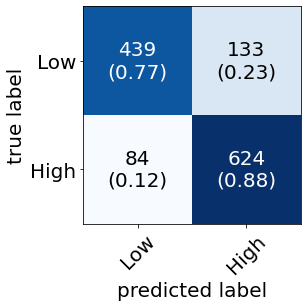

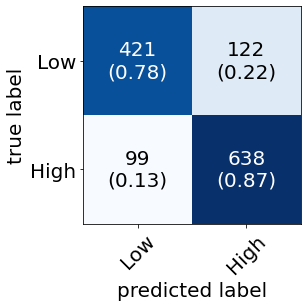

In [30]:
#===============================
# EEG results
#===============================

df = pd.read_csv(fname_eeg)
# print(df)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('EEG Valence accuracy:{}'.format(val_acc_score))
print('EEG Valence F1 Score:{}'.format(val_f1_scr))
print('Valence Confiusion matric:{}'.format(cm))

print(' ')

# print('Accuracy score', acc_score)

print('EEG Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence EEG.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('EEG Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('EEG Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('EEG Arousal Confiusion matric')
print(cm)

print(' ')

print('EEG Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal EEG.jpeg'

plt.savefig(fname2, bbox_inches='tight')

EDA Valence accuracy:
0.79140625
 
EDA Valence F1 Score
0.8126315789473685
 
EDA Valence Confiusion matric
[[434 138]
 [129 579]]
 
EDA Valence Classification Report
              precision    recall  f1-score   support

         Low       0.77      0.76      0.76       572
        High       0.81      0.82      0.81       708

    accuracy                           0.79      1280
   macro avg       0.79      0.79      0.79      1280
weighted avg       0.79      0.79      0.79      1280

EDA Arousal accuracy:
0.81484375
 
EDA Arousal F1 Score
0.8427339084273391
 
EDA Arousal Confiusion matric
[[408 135]
 [102 635]]
 
EDA Arousal classification Report
              precision    recall  f1-score   support

         Low       0.80      0.75      0.77       543
        High       0.82      0.86      0.84       737

    accuracy                           0.81      1280
   macro avg       0.81      0.81      0.81      1280
weighted avg       0.81      0.81      0.81      1280



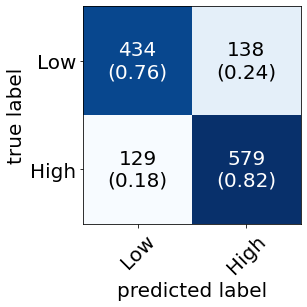

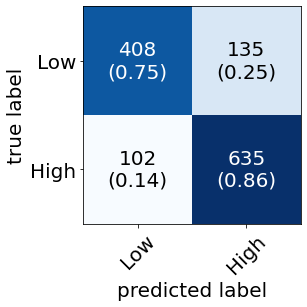

In [31]:
#===============================
# EDA results
#===============================

df = pd.read_csv(fname_eda)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('EDA Valence accuracy:')
print(val_acc_score)

print(' ')
print('EDA Valence F1 Score')
print(val_f1_scr)

print(' ')

print('EDA Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('EDA Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+classifier+'valence EDA.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('EDA Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('EDA Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('EDA Arousal Confiusion matric')
print(cm)

print(' ')

print('EDA Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal EDA.jpeg'

plt.savefig(fname2, bbox_inches='tight')

RESP BELT Valence accuracy:
0.85390625
 
RESP BELT Valence F1 Score
0.8728755948334467
 
RESP BELT Valence Confiusion matric
[[451 121]
 [ 66 642]]
 
RESP BELT Valence Classification Report
              precision    recall  f1-score   support

         Low       0.87      0.79      0.83       572
        High       0.84      0.91      0.87       708

    accuracy                           0.85      1280
   macro avg       0.86      0.85      0.85      1280
weighted avg       0.86      0.85      0.85      1280

RESP BELT Arousal accuracy:
0.903125
 
RESP BELT Arousal F1 Score
0.9187418086500656
 
RESP BELT Arousal Confiusion matric
[[455  88]
 [ 36 701]]
 
RESP BELT Arousal classification Report
              precision    recall  f1-score   support

         Low       0.93      0.84      0.88       543
        High       0.89      0.95      0.92       737

    accuracy                           0.90      1280
   macro avg       0.91      0.89      0.90      1280
weighted avg       0.90

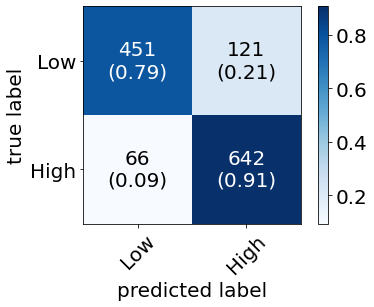

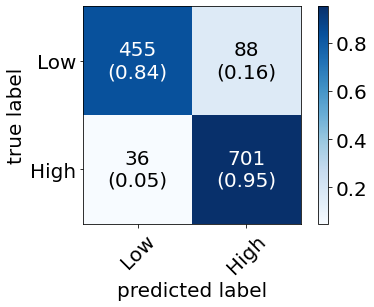

In [32]:
#===============================
# RESP BELT results
#===============================

df = pd.read_csv(fname_resp)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('RESP BELT Valence accuracy:')
print(val_acc_score)

print(' ')
print('RESP BELT Valence F1 Score')
print(val_f1_scr)

print(' ')

print('RESP BELT Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('RESP BELT Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+classifier+' valence RESP BELT.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('RESP BELT Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('RESP BELT Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('RESP BELT Arousal Confiusion matric')
print(cm)

print(' ')

print('RESP BELT Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal RESP BELT.jpeg'

plt.savefig(fname2, bbox_inches='tight')

MER Valence accuracy:
0.8515625
 
MER Valence F1 Score
0.8703956343792633
 
MER Valence Confiusion matric
[[452 120]
 [ 70 638]]
 
MER Valence Classification Report
              precision    recall  f1-score   support

         Low       0.87      0.79      0.83       572
        High       0.84      0.90      0.87       708

    accuracy                           0.85      1280
   macro avg       0.85      0.85      0.85      1280
weighted avg       0.85      0.85      0.85      1280

MER Arousal accuracy:
0.9015625
 
MER Arousal F1 Score
0.9173228346456692
 
MER Arousal Confiusion matric
[[455  88]
 [ 38 699]]
 
MER Arousal classification Report
              precision    recall  f1-score   support

         Low       0.92      0.84      0.88       543
        High       0.89      0.95      0.92       737

    accuracy                           0.90      1280
   macro avg       0.91      0.89      0.90      1280
weighted avg       0.90      0.90      0.90      1280



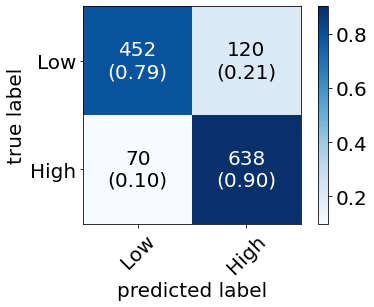

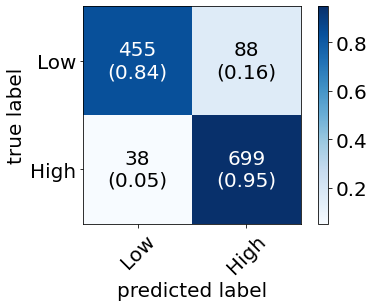

In [33]:
#==========================================
# Multi Modal Emotion Recognition results
#==========================================

df = pd.read_csv(fname_mer)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('MER Valence accuracy:')
print(val_acc_score)

print(' ')
print('MER Valence F1 Score')
print(val_f1_scr)

print(' ')

print('MER Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('MER Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+'LR-SGD valence MER.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('MER Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('MER Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('MER Arousal Confiusion matric')
print(cm)

print(' ')

print('MER Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+'LR-SGD arousal MER.jpeg'

plt.savefig(fname2, bbox_inches='tight')